In [1]:
import copy
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from tqdm import tqdm
np.random.seed(0)
torch.manual_seed(0)

/anaconda/envs/hw_094295_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
BATCH_SIZE = 16
NUM_EPOCHS = 500
LR = 0.001

base_dir = os.path.join("/home/student/hw2_094295", "all_data")
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")

In [3]:
def load_datasets(train_dir, val_dir):
    """Loads and transforms the datasets."""
    # Resize the samples and transform them into tensors
    data_transforms = transforms.Compose([transforms.Resize([64, 64]), transforms.ToTensor()])

    # Create a pytorch dataset from a directory of images
    train_dataset = datasets.ImageFolder(train_dir, data_transforms)
    val_dataset = datasets.ImageFolder(val_dir, data_transforms)

    return train_dataset, val_dataset


train_dataset, val_dataset = load_datasets(train_dir, val_dir)

class_names = train_dataset.classes
print("The classes are: ", class_names)

The classes are:  ['i', 'ii', 'iii', 'iv', 'ix', 'v', 'vi', 'vii', 'viii', 'x']


In [4]:
# Dataloaders initialization
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataloaders = {'train': train_dataloader, 'val': val_dataloader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

NUM_CLASSES = len(class_names)

In [6]:
def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=100):
    """Responsible for running the training and validation phases for the requested model."""
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    loss_dict = {'train': [], 'val': []}
    acc_dict = {'train': [], 'val': []}
    correctness_dict = {}
    real_probs_dict = {}
    labels_dict = {}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() 
            else:
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            for i, (inputs, labels) in enumerate(tqdm(dataloaders[phase])):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # track history only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                for j in range(len(outputs)):
                    image_key = f"{i}_{j}_{phase}"
                    output = outputs[j]
                    pred = int(preds[j])
                    real = int(labels.data[j])
                    probs = torch.nn.functional.softmax(output)
                    if image_key not in correctness_dict:
                        correctness_dict[image_key] = 0.0
                        real_probs_dict[image_key] = []
                        labels_dict[image_key] = class_names[real]
                        
                    correctness_dict[image_key] += int(pred == real)
                    real_probs_dict[image_key].append(float(probs[real]))

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            acc_dict[phase].append(epoch_acc.item())
            loss_dict[phase].append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # If the current epoch provides the best validation accuracy so far, save the model's weights.
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    confidence_dict = {}
    variablity_dict = {}

    for key, value in real_probs_dict.items():
        confidence_dict[key] = np.mean(value)
        variablity_dict[key] = np.std(value)

    for key, value in confidence_dict.items():
        correctness_dict[key] = value/NUM_EPOCHS
 
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, loss_dict, acc_dict, correctness_dict, confidence_dict, variablity_dict, labels_dict

In [7]:
model_ft = models.resnet50(pretrained=False)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, NUM_CLASSES)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model_ft.parameters(), lr=LR)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)
model_ft, loss_dict, acc_dict, correctness_dict, confidence_dict, variablity_dict, labels_dict = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, dataloaders, dataset_sizes, num_epochs=NUM_EPOCHS)

Epoch 1/500
----------


  0%|          | 0/130 [00:00<?, ?it/s]/tmp/ipykernel_111920/3700912852.py:52: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = torch.nn.functional.softmax(output)
100%|██████████| 130/130 [00:11<00:00, 11.51it/s]


train Loss: 2.5804 Acc: 0.1945


100%|██████████| 1/1 [00:00<00:00, 36.63it/s]


val Loss: 3.1754 Acc: 0.2000

Epoch 2/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.89it/s]


train Loss: 1.6871 Acc: 0.4349


100%|██████████| 1/1 [00:00<00:00, 36.71it/s]


val Loss: 1.5217 Acc: 0.6000

Epoch 3/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.87it/s]


train Loss: 1.2408 Acc: 0.5955


100%|██████████| 1/1 [00:00<00:00, 34.44it/s]


val Loss: 1.2862 Acc: 0.6000

Epoch 4/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.87it/s]


train Loss: 1.0156 Acc: 0.6817


100%|██████████| 1/1 [00:00<00:00, 33.86it/s]


val Loss: 0.7711 Acc: 0.8000

Epoch 5/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.86it/s]


train Loss: 0.8195 Acc: 0.7368


100%|██████████| 1/1 [00:00<00:00, 33.94it/s]


val Loss: 1.5601 Acc: 0.4000

Epoch 6/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.89it/s]


train Loss: 0.5408 Acc: 0.8302


100%|██████████| 1/1 [00:00<00:00, 34.45it/s]


val Loss: 0.3891 Acc: 0.9000

Epoch 7/500
----------


100%|██████████| 130/130 [00:11<00:00, 11.80it/s]


train Loss: 0.4107 Acc: 0.8694


100%|██████████| 1/1 [00:00<00:00, 36.09it/s]


val Loss: 0.4538 Acc: 0.8000

Epoch 8/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.84it/s]


train Loss: 0.3410 Acc: 0.8931


100%|██████████| 1/1 [00:00<00:00, 36.08it/s]


val Loss: 0.2507 Acc: 0.8000

Epoch 9/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.91it/s]


train Loss: 0.2726 Acc: 0.9226


100%|██████████| 1/1 [00:00<00:00, 33.64it/s]


val Loss: 0.3015 Acc: 0.9000

Epoch 10/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.84it/s]


train Loss: 0.2443 Acc: 0.9265


100%|██████████| 1/1 [00:00<00:00, 36.37it/s]


val Loss: 0.3815 Acc: 0.8000

Epoch 11/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.87it/s]


train Loss: 0.1947 Acc: 0.9439


100%|██████████| 1/1 [00:00<00:00, 36.70it/s]


val Loss: 0.3499 Acc: 0.8000

Epoch 12/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.88it/s]


train Loss: 0.1718 Acc: 0.9492


100%|██████████| 1/1 [00:00<00:00, 36.71it/s]


val Loss: 0.2847 Acc: 0.9000

Epoch 13/500
----------


100%|██████████| 130/130 [00:11<00:00, 11.74it/s]


train Loss: 0.1707 Acc: 0.9511


100%|██████████| 1/1 [00:00<00:00, 33.20it/s]


val Loss: 0.2998 Acc: 0.8000

Epoch 14/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.87it/s]


train Loss: 0.1693 Acc: 0.9560


100%|██████████| 1/1 [00:00<00:00, 36.90it/s]


val Loss: 0.3572 Acc: 0.9000

Epoch 15/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.88it/s]


train Loss: 0.1415 Acc: 0.9603


100%|██████████| 1/1 [00:00<00:00, 34.73it/s]


val Loss: 0.3939 Acc: 0.8000

Epoch 16/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.91it/s]


train Loss: 0.1392 Acc: 0.9627


100%|██████████| 1/1 [00:00<00:00, 35.87it/s]


val Loss: 0.3064 Acc: 0.8000

Epoch 17/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.82it/s]


train Loss: 0.1401 Acc: 0.9637


100%|██████████| 1/1 [00:00<00:00, 34.30it/s]


val Loss: 0.3908 Acc: 0.8000

Epoch 18/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.95it/s]


train Loss: 0.1328 Acc: 0.9652


100%|██████████| 1/1 [00:00<00:00, 36.86it/s]


val Loss: 0.3464 Acc: 0.8000

Epoch 19/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.07it/s]


train Loss: 0.1502 Acc: 0.9579


100%|██████████| 1/1 [00:00<00:00, 36.35it/s]


val Loss: 0.3323 Acc: 0.8000

Epoch 20/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.97it/s]


train Loss: 0.1404 Acc: 0.9594


100%|██████████| 1/1 [00:00<00:00, 34.81it/s]


val Loss: 0.3754 Acc: 0.9000

Epoch 21/500
----------


100%|██████████| 130/130 [00:11<00:00, 11.62it/s]


train Loss: 0.1283 Acc: 0.9661


100%|██████████| 1/1 [00:00<00:00, 35.64it/s]


val Loss: 0.3518 Acc: 0.9000

Epoch 22/500
----------


100%|██████████| 130/130 [00:11<00:00, 11.65it/s]


train Loss: 0.1422 Acc: 0.9603


100%|██████████| 1/1 [00:00<00:00, 33.73it/s]


val Loss: 0.3379 Acc: 0.9000

Epoch 23/500
----------


100%|██████████| 130/130 [00:11<00:00, 11.72it/s]


train Loss: 0.1398 Acc: 0.9603


100%|██████████| 1/1 [00:00<00:00, 36.48it/s]


val Loss: 0.4023 Acc: 0.8000

Epoch 24/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.89it/s]


train Loss: 0.1362 Acc: 0.9623


100%|██████████| 1/1 [00:00<00:00, 35.30it/s]


val Loss: 0.3857 Acc: 0.9000

Epoch 25/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.89it/s]


train Loss: 0.1389 Acc: 0.9584


100%|██████████| 1/1 [00:00<00:00, 33.86it/s]


val Loss: 0.2148 Acc: 0.9000

Epoch 26/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.89it/s]


train Loss: 0.1391 Acc: 0.9598


100%|██████████| 1/1 [00:00<00:00, 36.45it/s]


val Loss: 0.3739 Acc: 0.9000

Epoch 27/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.89it/s]


train Loss: 0.1303 Acc: 0.9657


100%|██████████| 1/1 [00:00<00:00, 32.98it/s]


val Loss: 0.3305 Acc: 0.9000

Epoch 28/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.89it/s]


train Loss: 0.1391 Acc: 0.9642


100%|██████████| 1/1 [00:00<00:00, 34.98it/s]


val Loss: 0.3826 Acc: 0.8000

Epoch 29/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.89it/s]


train Loss: 0.1479 Acc: 0.9545


100%|██████████| 1/1 [00:00<00:00, 35.23it/s]


val Loss: 0.3562 Acc: 0.8000

Epoch 30/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.93it/s]


train Loss: 0.1373 Acc: 0.9627


100%|██████████| 1/1 [00:00<00:00, 35.88it/s]


val Loss: 0.3752 Acc: 0.8000

Epoch 31/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.93it/s]


train Loss: 0.1317 Acc: 0.9637


100%|██████████| 1/1 [00:00<00:00, 36.10it/s]


val Loss: 0.4085 Acc: 0.9000

Epoch 32/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.89it/s]


train Loss: 0.1404 Acc: 0.9613


100%|██████████| 1/1 [00:00<00:00, 36.22it/s]


val Loss: 0.3144 Acc: 0.9000

Epoch 33/500
----------


100%|██████████| 130/130 [00:11<00:00, 11.74it/s]


train Loss: 0.1445 Acc: 0.9603


100%|██████████| 1/1 [00:00<00:00, 36.07it/s]


val Loss: 0.3726 Acc: 0.9000

Epoch 34/500
----------


100%|██████████| 130/130 [00:11<00:00, 11.73it/s]


train Loss: 0.1281 Acc: 0.9652


100%|██████████| 1/1 [00:00<00:00, 35.22it/s]


val Loss: 0.3572 Acc: 0.9000

Epoch 35/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.88it/s]


train Loss: 0.1309 Acc: 0.9676


100%|██████████| 1/1 [00:00<00:00, 34.91it/s]


val Loss: 0.4099 Acc: 0.8000

Epoch 36/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.88it/s]


train Loss: 0.1290 Acc: 0.9647


100%|██████████| 1/1 [00:00<00:00, 35.48it/s]


val Loss: 0.3646 Acc: 0.8000

Epoch 37/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.90it/s]


train Loss: 0.1477 Acc: 0.9550


100%|██████████| 1/1 [00:00<00:00, 35.66it/s]


val Loss: 0.3186 Acc: 0.8000

Epoch 38/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.89it/s]


train Loss: 0.1408 Acc: 0.9594


100%|██████████| 1/1 [00:00<00:00, 33.66it/s]


val Loss: 0.3843 Acc: 0.8000

Epoch 39/500
----------


100%|██████████| 130/130 [00:11<00:00, 11.67it/s]


train Loss: 0.1433 Acc: 0.9560


100%|██████████| 1/1 [00:00<00:00, 33.47it/s]


val Loss: 0.4107 Acc: 0.8000

Epoch 40/500
----------


100%|██████████| 130/130 [00:11<00:00, 11.67it/s]


train Loss: 0.1376 Acc: 0.9598


100%|██████████| 1/1 [00:00<00:00, 31.65it/s]


val Loss: 0.3264 Acc: 0.8000

Epoch 41/500
----------


100%|██████████| 130/130 [00:11<00:00, 11.65it/s]


train Loss: 0.1439 Acc: 0.9565


100%|██████████| 1/1 [00:00<00:00, 33.27it/s]


val Loss: 0.3872 Acc: 0.8000

Epoch 42/500
----------


100%|██████████| 130/130 [00:11<00:00, 11.73it/s]


train Loss: 0.1375 Acc: 0.9642


100%|██████████| 1/1 [00:00<00:00, 36.30it/s]


val Loss: 0.5075 Acc: 0.8000

Epoch 43/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.93it/s]


train Loss: 0.1298 Acc: 0.9657


100%|██████████| 1/1 [00:00<00:00, 36.89it/s]


val Loss: 0.3428 Acc: 0.8000

Epoch 44/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.97it/s]


train Loss: 0.1444 Acc: 0.9565


100%|██████████| 1/1 [00:00<00:00, 36.37it/s]


val Loss: 0.3333 Acc: 0.9000

Epoch 45/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.85it/s]


train Loss: 0.1363 Acc: 0.9647


100%|██████████| 1/1 [00:00<00:00, 36.26it/s]


val Loss: 0.4244 Acc: 0.8000

Epoch 46/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.97it/s]


train Loss: 0.1356 Acc: 0.9623


100%|██████████| 1/1 [00:00<00:00, 36.36it/s]


val Loss: 0.4136 Acc: 0.8000

Epoch 47/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.97it/s]


train Loss: 0.1344 Acc: 0.9632


100%|██████████| 1/1 [00:00<00:00, 36.55it/s]


val Loss: 0.3488 Acc: 0.9000

Epoch 48/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.04it/s]


train Loss: 0.1316 Acc: 0.9671


100%|██████████| 1/1 [00:00<00:00, 35.95it/s]


val Loss: 0.3896 Acc: 0.8000

Epoch 49/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.05it/s]


train Loss: 0.1310 Acc: 0.9681


100%|██████████| 1/1 [00:00<00:00, 34.61it/s]


val Loss: 0.3329 Acc: 0.9000

Epoch 50/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.08it/s]


train Loss: 0.1471 Acc: 0.9574


100%|██████████| 1/1 [00:00<00:00, 36.23it/s]


val Loss: 0.4699 Acc: 0.8000

Epoch 51/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.01it/s]


train Loss: 0.1442 Acc: 0.9594


100%|██████████| 1/1 [00:00<00:00, 36.62it/s]


val Loss: 0.3286 Acc: 0.8000

Epoch 52/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.05it/s]


train Loss: 0.1307 Acc: 0.9686


100%|██████████| 1/1 [00:00<00:00, 36.21it/s]


val Loss: 0.4334 Acc: 0.8000

Epoch 53/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.02it/s]


train Loss: 0.1406 Acc: 0.9560


100%|██████████| 1/1 [00:00<00:00, 36.69it/s]


val Loss: 0.3514 Acc: 0.8000

Epoch 54/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.04it/s]


train Loss: 0.1391 Acc: 0.9647


100%|██████████| 1/1 [00:00<00:00, 36.73it/s]


val Loss: 0.3375 Acc: 0.8000

Epoch 55/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.00it/s]


train Loss: 0.1312 Acc: 0.9652


100%|██████████| 1/1 [00:00<00:00, 36.43it/s]


val Loss: 0.3864 Acc: 0.8000

Epoch 56/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.02it/s]


train Loss: 0.1374 Acc: 0.9657


100%|██████████| 1/1 [00:00<00:00, 37.03it/s]


val Loss: 0.4106 Acc: 0.8000

Epoch 57/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.08it/s]


train Loss: 0.1320 Acc: 0.9666


100%|██████████| 1/1 [00:00<00:00, 36.71it/s]


val Loss: 0.3481 Acc: 0.9000

Epoch 58/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.06it/s]


train Loss: 0.1436 Acc: 0.9594


100%|██████████| 1/1 [00:00<00:00, 36.88it/s]


val Loss: 0.3705 Acc: 0.9000

Epoch 59/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.08it/s]


train Loss: 0.1403 Acc: 0.9598


100%|██████████| 1/1 [00:00<00:00, 36.39it/s]


val Loss: 0.3633 Acc: 0.8000

Epoch 60/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.07it/s]


train Loss: 0.1429 Acc: 0.9589


100%|██████████| 1/1 [00:00<00:00, 36.65it/s]


val Loss: 0.3171 Acc: 0.9000

Epoch 61/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.09it/s]


train Loss: 0.1246 Acc: 0.9710


100%|██████████| 1/1 [00:00<00:00, 36.95it/s]


val Loss: 0.4108 Acc: 0.8000

Epoch 62/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.94it/s]


train Loss: 0.1406 Acc: 0.9594


100%|██████████| 1/1 [00:00<00:00, 34.67it/s]


val Loss: 0.3228 Acc: 0.9000

Epoch 63/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.89it/s]


train Loss: 0.1348 Acc: 0.9661


100%|██████████| 1/1 [00:00<00:00, 35.55it/s]


val Loss: 0.3589 Acc: 0.9000

Epoch 64/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.92it/s]


train Loss: 0.1388 Acc: 0.9598


100%|██████████| 1/1 [00:00<00:00, 34.53it/s]


val Loss: 0.3124 Acc: 0.9000

Epoch 65/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.88it/s]


train Loss: 0.1361 Acc: 0.9637


100%|██████████| 1/1 [00:00<00:00, 34.13it/s]


val Loss: 0.3236 Acc: 0.9000

Epoch 66/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.87it/s]


train Loss: 0.1337 Acc: 0.9637


100%|██████████| 1/1 [00:00<00:00, 34.36it/s]


val Loss: 0.3928 Acc: 0.8000

Epoch 67/500
----------


100%|██████████| 130/130 [00:11<00:00, 11.77it/s]


train Loss: 0.1402 Acc: 0.9632


100%|██████████| 1/1 [00:00<00:00, 34.00it/s]


val Loss: 0.3079 Acc: 0.8000

Epoch 68/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.89it/s]


train Loss: 0.1503 Acc: 0.9598


100%|██████████| 1/1 [00:00<00:00, 37.17it/s]


val Loss: 0.3567 Acc: 0.8000

Epoch 69/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.85it/s]


train Loss: 0.1472 Acc: 0.9598


100%|██████████| 1/1 [00:00<00:00, 33.81it/s]


val Loss: 0.3826 Acc: 0.9000

Epoch 70/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.87it/s]


train Loss: 0.1350 Acc: 0.9613


100%|██████████| 1/1 [00:00<00:00, 36.83it/s]


val Loss: 0.4885 Acc: 0.8000

Epoch 71/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.91it/s]


train Loss: 0.1327 Acc: 0.9671


100%|██████████| 1/1 [00:00<00:00, 34.85it/s]


val Loss: 0.3346 Acc: 0.9000

Epoch 72/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.93it/s]


train Loss: 0.1301 Acc: 0.9700


100%|██████████| 1/1 [00:00<00:00, 37.14it/s]


val Loss: 0.3045 Acc: 0.8000

Epoch 73/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.99it/s]


train Loss: 0.1432 Acc: 0.9618


100%|██████████| 1/1 [00:00<00:00, 37.00it/s]


val Loss: 0.3503 Acc: 0.8000

Epoch 74/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.07it/s]


train Loss: 0.1313 Acc: 0.9608


100%|██████████| 1/1 [00:00<00:00, 36.55it/s]


val Loss: 0.3704 Acc: 0.9000

Epoch 75/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.04it/s]


train Loss: 0.1379 Acc: 0.9666


100%|██████████| 1/1 [00:00<00:00, 36.24it/s]


val Loss: 0.5307 Acc: 0.8000

Epoch 76/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.01it/s]


train Loss: 0.1439 Acc: 0.9589


100%|██████████| 1/1 [00:00<00:00, 36.97it/s]


val Loss: 0.2773 Acc: 0.9000

Epoch 77/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.98it/s]


train Loss: 0.1420 Acc: 0.9594


100%|██████████| 1/1 [00:00<00:00, 35.72it/s]


val Loss: 0.3600 Acc: 0.9000

Epoch 78/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.00it/s]


train Loss: 0.1410 Acc: 0.9598


100%|██████████| 1/1 [00:00<00:00, 36.94it/s]


val Loss: 0.3983 Acc: 0.8000

Epoch 79/500
----------


100%|██████████| 130/130 [00:11<00:00, 11.80it/s]


train Loss: 0.1294 Acc: 0.9652


100%|██████████| 1/1 [00:00<00:00, 34.45it/s]


val Loss: 0.4462 Acc: 0.8000

Epoch 80/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.04it/s]


train Loss: 0.1444 Acc: 0.9560


100%|██████████| 1/1 [00:00<00:00, 36.53it/s]


val Loss: 0.3032 Acc: 0.9000

Epoch 81/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.07it/s]


train Loss: 0.1415 Acc: 0.9603


100%|██████████| 1/1 [00:00<00:00, 36.36it/s]


val Loss: 0.3767 Acc: 0.8000

Epoch 82/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.04it/s]


train Loss: 0.1354 Acc: 0.9594


100%|██████████| 1/1 [00:00<00:00, 33.18it/s]


val Loss: 0.3959 Acc: 0.9000

Epoch 83/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.99it/s]


train Loss: 0.1373 Acc: 0.9623


100%|██████████| 1/1 [00:00<00:00, 28.33it/s]


val Loss: 0.4034 Acc: 0.9000

Epoch 84/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.96it/s]


train Loss: 0.1488 Acc: 0.9569


100%|██████████| 1/1 [00:00<00:00, 36.97it/s]


val Loss: 0.3123 Acc: 0.9000

Epoch 85/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.06it/s]


train Loss: 0.1312 Acc: 0.9657


100%|██████████| 1/1 [00:00<00:00, 36.69it/s]


val Loss: 0.2721 Acc: 0.9000

Epoch 86/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.04it/s]


train Loss: 0.1359 Acc: 0.9657


100%|██████████| 1/1 [00:00<00:00, 36.27it/s]


val Loss: 0.4323 Acc: 0.9000

Epoch 87/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.00it/s]


train Loss: 0.1436 Acc: 0.9594


100%|██████████| 1/1 [00:00<00:00, 35.73it/s]


val Loss: 0.3888 Acc: 0.9000

Epoch 88/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.07it/s]


train Loss: 0.1385 Acc: 0.9613


100%|██████████| 1/1 [00:00<00:00, 36.39it/s]


val Loss: 0.3257 Acc: 0.9000

Epoch 89/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.01it/s]


train Loss: 0.1263 Acc: 0.9686


100%|██████████| 1/1 [00:00<00:00, 35.77it/s]


val Loss: 0.3692 Acc: 0.8000

Epoch 90/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.08it/s]


train Loss: 0.1298 Acc: 0.9657


100%|██████████| 1/1 [00:00<00:00, 37.05it/s]


val Loss: 0.3838 Acc: 0.9000

Epoch 91/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.10it/s]


train Loss: 0.1395 Acc: 0.9613


100%|██████████| 1/1 [00:00<00:00, 37.05it/s]


val Loss: 0.4252 Acc: 0.8000

Epoch 92/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.07it/s]


train Loss: 0.1422 Acc: 0.9574


100%|██████████| 1/1 [00:00<00:00, 36.74it/s]


val Loss: 0.4531 Acc: 0.8000

Epoch 93/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.10it/s]


train Loss: 0.1434 Acc: 0.9603


100%|██████████| 1/1 [00:00<00:00, 36.54it/s]


val Loss: 0.3777 Acc: 0.8000

Epoch 94/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.08it/s]


train Loss: 0.1397 Acc: 0.9613


100%|██████████| 1/1 [00:00<00:00, 36.14it/s]


val Loss: 0.3559 Acc: 0.8000

Epoch 95/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.00it/s]


train Loss: 0.1387 Acc: 0.9608


100%|██████████| 1/1 [00:00<00:00, 33.94it/s]


val Loss: 0.2869 Acc: 0.9000

Epoch 96/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.90it/s]


train Loss: 0.1385 Acc: 0.9613


100%|██████████| 1/1 [00:00<00:00, 37.17it/s]


val Loss: 0.4161 Acc: 0.8000

Epoch 97/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.86it/s]


train Loss: 0.1380 Acc: 0.9637


100%|██████████| 1/1 [00:00<00:00, 35.64it/s]


val Loss: 0.4637 Acc: 0.8000

Epoch 98/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.94it/s]


train Loss: 0.1381 Acc: 0.9642


100%|██████████| 1/1 [00:00<00:00, 36.44it/s]


val Loss: 0.3784 Acc: 0.8000

Epoch 99/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.06it/s]


train Loss: 0.1417 Acc: 0.9613


100%|██████████| 1/1 [00:00<00:00, 37.05it/s]


val Loss: 0.4069 Acc: 0.8000

Epoch 100/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.02it/s]


train Loss: 0.1412 Acc: 0.9603


100%|██████████| 1/1 [00:00<00:00, 36.63it/s]


val Loss: 0.2708 Acc: 0.9000

Epoch 101/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.97it/s]


train Loss: 0.1399 Acc: 0.9613


100%|██████████| 1/1 [00:00<00:00, 37.12it/s]


val Loss: 0.4448 Acc: 0.8000

Epoch 102/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.06it/s]


train Loss: 0.1326 Acc: 0.9652


100%|██████████| 1/1 [00:00<00:00, 36.57it/s]


val Loss: 0.4087 Acc: 0.8000

Epoch 103/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.04it/s]


train Loss: 0.1406 Acc: 0.9632


100%|██████████| 1/1 [00:00<00:00, 36.83it/s]


val Loss: 0.3323 Acc: 0.8000

Epoch 104/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.03it/s]


train Loss: 0.1454 Acc: 0.9589


100%|██████████| 1/1 [00:00<00:00, 36.88it/s]


val Loss: 0.3516 Acc: 0.9000

Epoch 105/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.09it/s]


train Loss: 0.1400 Acc: 0.9574


100%|██████████| 1/1 [00:00<00:00, 37.13it/s]


val Loss: 0.3233 Acc: 0.9000

Epoch 106/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.04it/s]


train Loss: 0.1285 Acc: 0.9690


100%|██████████| 1/1 [00:00<00:00, 36.44it/s]


val Loss: 0.3585 Acc: 0.9000

Epoch 107/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.10it/s]


train Loss: 0.1335 Acc: 0.9608


100%|██████████| 1/1 [00:00<00:00, 36.18it/s]


val Loss: 0.4120 Acc: 0.8000

Epoch 108/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.10it/s]


train Loss: 0.1446 Acc: 0.9589


100%|██████████| 1/1 [00:00<00:00, 36.70it/s]


val Loss: 0.3780 Acc: 0.8000

Epoch 109/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.06it/s]


train Loss: 0.1377 Acc: 0.9613


100%|██████████| 1/1 [00:00<00:00, 37.04it/s]


val Loss: 0.4647 Acc: 0.9000

Epoch 110/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.11it/s]


train Loss: 0.1390 Acc: 0.9623


100%|██████████| 1/1 [00:00<00:00, 36.00it/s]


val Loss: 0.2732 Acc: 0.9000

Epoch 111/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.10it/s]


train Loss: 0.1358 Acc: 0.9632


100%|██████████| 1/1 [00:00<00:00, 35.29it/s]


val Loss: 0.3704 Acc: 0.9000

Epoch 112/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.13it/s]


train Loss: 0.1326 Acc: 0.9652


100%|██████████| 1/1 [00:00<00:00, 37.21it/s]


val Loss: 0.3478 Acc: 0.8000

Epoch 113/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.13it/s]


train Loss: 0.1377 Acc: 0.9623


100%|██████████| 1/1 [00:00<00:00, 37.55it/s]


val Loss: 0.3616 Acc: 0.9000

Epoch 114/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.07it/s]


train Loss: 0.1308 Acc: 0.9627


100%|██████████| 1/1 [00:00<00:00, 36.69it/s]


val Loss: 0.3190 Acc: 0.9000

Epoch 115/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.12it/s]


train Loss: 0.1354 Acc: 0.9666


100%|██████████| 1/1 [00:00<00:00, 36.16it/s]


val Loss: 0.3727 Acc: 0.9000

Epoch 116/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.15it/s]


train Loss: 0.1387 Acc: 0.9603


100%|██████████| 1/1 [00:00<00:00, 37.00it/s]


val Loss: 0.3754 Acc: 0.8000

Epoch 117/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.10it/s]


train Loss: 0.1342 Acc: 0.9608


100%|██████████| 1/1 [00:00<00:00, 36.49it/s]


val Loss: 0.3566 Acc: 0.8000

Epoch 118/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.11it/s]


train Loss: 0.1535 Acc: 0.9565


100%|██████████| 1/1 [00:00<00:00, 36.33it/s]


val Loss: 0.3900 Acc: 0.8000

Epoch 119/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.17it/s]


train Loss: 0.1277 Acc: 0.9676


100%|██████████| 1/1 [00:00<00:00, 35.59it/s]


val Loss: 0.3343 Acc: 0.9000

Epoch 120/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.16it/s]


train Loss: 0.1352 Acc: 0.9666


100%|██████████| 1/1 [00:00<00:00, 37.49it/s]


val Loss: 0.5350 Acc: 0.8000

Epoch 121/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.17it/s]


train Loss: 0.1406 Acc: 0.9608


100%|██████████| 1/1 [00:00<00:00, 36.85it/s]


val Loss: 0.4316 Acc: 0.8000

Epoch 122/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.15it/s]


train Loss: 0.1396 Acc: 0.9637


100%|██████████| 1/1 [00:00<00:00, 34.03it/s]


val Loss: 0.4252 Acc: 0.8000

Epoch 123/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.11it/s]


train Loss: 0.1391 Acc: 0.9598


100%|██████████| 1/1 [00:00<00:00, 37.09it/s]


val Loss: 0.4277 Acc: 0.8000

Epoch 124/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.14it/s]


train Loss: 0.1323 Acc: 0.9705


100%|██████████| 1/1 [00:00<00:00, 37.23it/s]


val Loss: 0.3636 Acc: 0.8000

Epoch 125/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.17it/s]


train Loss: 0.1412 Acc: 0.9642


100%|██████████| 1/1 [00:00<00:00, 36.29it/s]


val Loss: 0.3044 Acc: 0.9000

Epoch 126/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.06it/s]


train Loss: 0.1330 Acc: 0.9637


100%|██████████| 1/1 [00:00<00:00, 37.37it/s]


val Loss: 0.3988 Acc: 0.8000

Epoch 127/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.08it/s]


train Loss: 0.1372 Acc: 0.9652


100%|██████████| 1/1 [00:00<00:00, 35.79it/s]


val Loss: 0.3508 Acc: 0.8000

Epoch 128/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.07it/s]


train Loss: 0.1418 Acc: 0.9594


100%|██████████| 1/1 [00:00<00:00, 36.84it/s]


val Loss: 0.3221 Acc: 0.8000

Epoch 129/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.11it/s]


train Loss: 0.1359 Acc: 0.9661


100%|██████████| 1/1 [00:00<00:00, 37.00it/s]


val Loss: 0.4221 Acc: 0.9000

Epoch 130/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.06it/s]


train Loss: 0.1401 Acc: 0.9657


100%|██████████| 1/1 [00:00<00:00, 35.94it/s]


val Loss: 0.4648 Acc: 0.8000

Epoch 131/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.02it/s]


train Loss: 0.1423 Acc: 0.9613


100%|██████████| 1/1 [00:00<00:00, 37.25it/s]


val Loss: 0.3565 Acc: 0.9000

Epoch 132/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.04it/s]


train Loss: 0.1307 Acc: 0.9657


100%|██████████| 1/1 [00:00<00:00, 36.45it/s]


val Loss: 0.3491 Acc: 0.9000

Epoch 133/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.15it/s]


train Loss: 0.1320 Acc: 0.9681


100%|██████████| 1/1 [00:00<00:00, 37.08it/s]


val Loss: 0.4883 Acc: 0.8000

Epoch 134/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.96it/s]


train Loss: 0.1412 Acc: 0.9608


100%|██████████| 1/1 [00:00<00:00, 34.78it/s]


val Loss: 0.3717 Acc: 0.8000

Epoch 135/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.91it/s]


train Loss: 0.1388 Acc: 0.9613


100%|██████████| 1/1 [00:00<00:00, 36.16it/s]


val Loss: 0.3513 Acc: 0.9000

Epoch 136/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.93it/s]


train Loss: 0.1348 Acc: 0.9642


100%|██████████| 1/1 [00:00<00:00, 35.53it/s]


val Loss: 0.3735 Acc: 0.9000

Epoch 137/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.01it/s]


train Loss: 0.1390 Acc: 0.9613


100%|██████████| 1/1 [00:00<00:00, 37.25it/s]


val Loss: 0.4048 Acc: 0.8000

Epoch 138/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.04it/s]


train Loss: 0.1413 Acc: 0.9613


100%|██████████| 1/1 [00:00<00:00, 36.93it/s]


val Loss: 0.4012 Acc: 0.8000

Epoch 139/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.00it/s]


train Loss: 0.1356 Acc: 0.9632


100%|██████████| 1/1 [00:00<00:00, 37.50it/s]


val Loss: 0.3004 Acc: 0.9000

Epoch 140/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.11it/s]


train Loss: 0.1395 Acc: 0.9565


100%|██████████| 1/1 [00:00<00:00, 36.57it/s]


val Loss: 0.3603 Acc: 0.9000

Epoch 141/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.09it/s]


train Loss: 0.1426 Acc: 0.9618


100%|██████████| 1/1 [00:00<00:00, 36.82it/s]


val Loss: 0.4261 Acc: 0.8000

Epoch 142/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.10it/s]


train Loss: 0.1328 Acc: 0.9623


100%|██████████| 1/1 [00:00<00:00, 33.61it/s]


val Loss: 0.4200 Acc: 0.9000

Epoch 143/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.95it/s]


train Loss: 0.1437 Acc: 0.9594


100%|██████████| 1/1 [00:00<00:00, 36.54it/s]


val Loss: 0.3991 Acc: 0.9000

Epoch 144/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.08it/s]


train Loss: 0.1405 Acc: 0.9589


100%|██████████| 1/1 [00:00<00:00, 36.24it/s]


val Loss: 0.5329 Acc: 0.8000

Epoch 145/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.99it/s]


train Loss: 0.1415 Acc: 0.9623


100%|██████████| 1/1 [00:00<00:00, 36.42it/s]


val Loss: 0.3705 Acc: 0.9000

Epoch 146/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.03it/s]


train Loss: 0.1368 Acc: 0.9623


100%|██████████| 1/1 [00:00<00:00, 36.66it/s]


val Loss: 0.4073 Acc: 0.9000

Epoch 147/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.07it/s]


train Loss: 0.1260 Acc: 0.9642


100%|██████████| 1/1 [00:00<00:00, 36.58it/s]


val Loss: 0.3807 Acc: 0.9000

Epoch 148/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.04it/s]


train Loss: 0.1453 Acc: 0.9584


100%|██████████| 1/1 [00:00<00:00, 36.75it/s]


val Loss: 0.2841 Acc: 0.9000

Epoch 149/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.05it/s]


train Loss: 0.1406 Acc: 0.9632


100%|██████████| 1/1 [00:00<00:00, 36.50it/s]


val Loss: 0.5199 Acc: 0.8000

Epoch 150/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.97it/s]


train Loss: 0.1363 Acc: 0.9666


100%|██████████| 1/1 [00:00<00:00, 36.49it/s]


val Loss: 0.3169 Acc: 0.9000

Epoch 151/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.91it/s]


train Loss: 0.1467 Acc: 0.9584


100%|██████████| 1/1 [00:00<00:00, 36.60it/s]


val Loss: 0.3615 Acc: 0.8000

Epoch 152/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.06it/s]


train Loss: 0.1401 Acc: 0.9589


100%|██████████| 1/1 [00:00<00:00, 37.74it/s]


val Loss: 0.3583 Acc: 0.9000

Epoch 153/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.04it/s]


train Loss: 0.1446 Acc: 0.9589


100%|██████████| 1/1 [00:00<00:00, 37.16it/s]


val Loss: 0.3678 Acc: 0.9000

Epoch 154/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.02it/s]


train Loss: 0.1496 Acc: 0.9623


100%|██████████| 1/1 [00:00<00:00, 35.86it/s]


val Loss: 0.3779 Acc: 0.8000

Epoch 155/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.05it/s]


train Loss: 0.1344 Acc: 0.9637


100%|██████████| 1/1 [00:00<00:00, 35.69it/s]


val Loss: 0.4435 Acc: 0.8000

Epoch 156/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.06it/s]


train Loss: 0.1335 Acc: 0.9623


100%|██████████| 1/1 [00:00<00:00, 36.22it/s]


val Loss: 0.3871 Acc: 0.8000

Epoch 157/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.04it/s]


train Loss: 0.1415 Acc: 0.9613


100%|██████████| 1/1 [00:00<00:00, 35.27it/s]


val Loss: 0.4329 Acc: 0.8000

Epoch 158/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.95it/s]


train Loss: 0.1329 Acc: 0.9681


100%|██████████| 1/1 [00:00<00:00, 36.83it/s]


val Loss: 0.4120 Acc: 0.8000

Epoch 159/500
----------


100%|██████████| 130/130 [00:11<00:00, 11.78it/s]


train Loss: 0.1339 Acc: 0.9603


100%|██████████| 1/1 [00:00<00:00, 35.84it/s]


val Loss: 0.4071 Acc: 0.8000

Epoch 160/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.97it/s]


train Loss: 0.1453 Acc: 0.9613


100%|██████████| 1/1 [00:00<00:00, 36.49it/s]


val Loss: 0.4211 Acc: 0.8000

Epoch 161/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.99it/s]


train Loss: 0.1376 Acc: 0.9627


100%|██████████| 1/1 [00:00<00:00, 35.32it/s]


val Loss: 0.3918 Acc: 0.8000

Epoch 162/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.98it/s]


train Loss: 0.1310 Acc: 0.9608


100%|██████████| 1/1 [00:00<00:00, 36.82it/s]


val Loss: 0.3490 Acc: 0.9000

Epoch 163/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.99it/s]


train Loss: 0.1316 Acc: 0.9671


100%|██████████| 1/1 [00:00<00:00, 34.16it/s]


val Loss: 0.4346 Acc: 0.8000

Epoch 164/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.01it/s]


train Loss: 0.1341 Acc: 0.9705


100%|██████████| 1/1 [00:00<00:00, 31.90it/s]


val Loss: 0.3016 Acc: 0.9000

Epoch 165/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.02it/s]


train Loss: 0.1340 Acc: 0.9676


100%|██████████| 1/1 [00:00<00:00, 36.45it/s]


val Loss: 0.4161 Acc: 0.8000

Epoch 166/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.99it/s]


train Loss: 0.1341 Acc: 0.9637


100%|██████████| 1/1 [00:00<00:00, 37.23it/s]


val Loss: 0.3214 Acc: 0.9000

Epoch 167/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.96it/s]


train Loss: 0.1317 Acc: 0.9710


100%|██████████| 1/1 [00:00<00:00, 35.74it/s]


val Loss: 0.3842 Acc: 0.9000

Epoch 168/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.99it/s]


train Loss: 0.1361 Acc: 0.9594


100%|██████████| 1/1 [00:00<00:00, 36.67it/s]


val Loss: 0.3207 Acc: 0.9000

Epoch 169/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.02it/s]


train Loss: 0.1401 Acc: 0.9637


100%|██████████| 1/1 [00:00<00:00, 36.09it/s]


val Loss: 0.4993 Acc: 0.8000

Epoch 170/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.02it/s]


train Loss: 0.1438 Acc: 0.9589


100%|██████████| 1/1 [00:00<00:00, 35.37it/s]


val Loss: 0.3177 Acc: 0.9000

Epoch 171/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.02it/s]


train Loss: 0.1377 Acc: 0.9603


100%|██████████| 1/1 [00:00<00:00, 36.13it/s]


val Loss: 0.3504 Acc: 0.9000

Epoch 172/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.02it/s]


train Loss: 0.1464 Acc: 0.9627


100%|██████████| 1/1 [00:00<00:00, 36.33it/s]


val Loss: 0.3452 Acc: 0.8000

Epoch 173/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.03it/s]


train Loss: 0.1349 Acc: 0.9652


100%|██████████| 1/1 [00:00<00:00, 36.09it/s]


val Loss: 0.3953 Acc: 0.8000

Epoch 174/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.07it/s]


train Loss: 0.1324 Acc: 0.9637


100%|██████████| 1/1 [00:00<00:00, 35.62it/s]


val Loss: 0.3003 Acc: 0.9000

Epoch 175/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.07it/s]


train Loss: 0.1419 Acc: 0.9613


100%|██████████| 1/1 [00:00<00:00, 36.62it/s]


val Loss: 0.4849 Acc: 0.8000

Epoch 176/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.06it/s]


train Loss: 0.1352 Acc: 0.9632


100%|██████████| 1/1 [00:00<00:00, 36.60it/s]


val Loss: 0.3499 Acc: 0.9000

Epoch 177/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.04it/s]


train Loss: 0.1314 Acc: 0.9676


100%|██████████| 1/1 [00:00<00:00, 35.95it/s]


val Loss: 0.3668 Acc: 0.8000

Epoch 178/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.91it/s]


train Loss: 0.1353 Acc: 0.9666


100%|██████████| 1/1 [00:00<00:00, 33.79it/s]


val Loss: 0.4164 Acc: 0.8000

Epoch 179/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.83it/s]


train Loss: 0.1328 Acc: 0.9652


100%|██████████| 1/1 [00:00<00:00, 33.90it/s]


val Loss: 0.2900 Acc: 0.9000

Epoch 180/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.83it/s]


train Loss: 0.1335 Acc: 0.9627


100%|██████████| 1/1 [00:00<00:00, 33.74it/s]


val Loss: 0.3645 Acc: 0.8000

Epoch 181/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.83it/s]


train Loss: 0.1324 Acc: 0.9632


100%|██████████| 1/1 [00:00<00:00, 33.73it/s]


val Loss: 0.3595 Acc: 0.8000

Epoch 182/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.92it/s]


train Loss: 0.1403 Acc: 0.9623


100%|██████████| 1/1 [00:00<00:00, 34.08it/s]


val Loss: 0.4049 Acc: 0.9000

Epoch 183/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.87it/s]


train Loss: 0.1491 Acc: 0.9584


100%|██████████| 1/1 [00:00<00:00, 34.05it/s]


val Loss: 0.3674 Acc: 0.9000

Epoch 184/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.99it/s]


train Loss: 0.1349 Acc: 0.9613


100%|██████████| 1/1 [00:00<00:00, 36.97it/s]


val Loss: 0.3724 Acc: 0.8000

Epoch 185/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.02it/s]


train Loss: 0.1422 Acc: 0.9584


100%|██████████| 1/1 [00:00<00:00, 36.39it/s]


val Loss: 0.3467 Acc: 0.9000

Epoch 186/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.84it/s]


train Loss: 0.1342 Acc: 0.9661


100%|██████████| 1/1 [00:00<00:00, 34.20it/s]


val Loss: 0.4328 Acc: 0.9000

Epoch 187/500
----------


100%|██████████| 130/130 [00:11<00:00, 11.78it/s]


train Loss: 0.1397 Acc: 0.9637


100%|██████████| 1/1 [00:00<00:00, 34.96it/s]


val Loss: 0.4076 Acc: 0.8000

Epoch 188/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.83it/s]


train Loss: 0.1389 Acc: 0.9632


100%|██████████| 1/1 [00:00<00:00, 34.77it/s]


val Loss: 0.3183 Acc: 0.9000

Epoch 189/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.92it/s]


train Loss: 0.1330 Acc: 0.9627


100%|██████████| 1/1 [00:00<00:00, 36.29it/s]


val Loss: 0.4849 Acc: 0.8000

Epoch 190/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.01it/s]


train Loss: 0.1281 Acc: 0.9637


100%|██████████| 1/1 [00:00<00:00, 37.05it/s]


val Loss: 0.3089 Acc: 0.9000

Epoch 191/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.00it/s]


train Loss: 0.1323 Acc: 0.9690


100%|██████████| 1/1 [00:00<00:00, 36.42it/s]


val Loss: 0.4046 Acc: 0.8000

Epoch 192/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.97it/s]


train Loss: 0.1405 Acc: 0.9618


100%|██████████| 1/1 [00:00<00:00, 34.83it/s]


val Loss: 0.4257 Acc: 0.9000

Epoch 193/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.96it/s]


train Loss: 0.1446 Acc: 0.9594


100%|██████████| 1/1 [00:00<00:00, 34.84it/s]


val Loss: 0.4164 Acc: 0.8000

Epoch 194/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.95it/s]


train Loss: 0.1355 Acc: 0.9613


100%|██████████| 1/1 [00:00<00:00, 35.38it/s]


val Loss: 0.4465 Acc: 0.8000

Epoch 195/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.01it/s]


train Loss: 0.1406 Acc: 0.9623


100%|██████████| 1/1 [00:00<00:00, 35.53it/s]


val Loss: 0.4037 Acc: 0.8000

Epoch 196/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.99it/s]


train Loss: 0.1280 Acc: 0.9661


100%|██████████| 1/1 [00:00<00:00, 35.46it/s]


val Loss: 0.3518 Acc: 0.9000

Epoch 197/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.05it/s]


train Loss: 0.1299 Acc: 0.9676


100%|██████████| 1/1 [00:00<00:00, 36.47it/s]


val Loss: 0.4020 Acc: 0.8000

Epoch 198/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.92it/s]


train Loss: 0.1237 Acc: 0.9710


100%|██████████| 1/1 [00:00<00:00, 36.08it/s]


val Loss: 0.4456 Acc: 0.8000

Epoch 199/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.97it/s]


train Loss: 0.1451 Acc: 0.9579


100%|██████████| 1/1 [00:00<00:00, 37.30it/s]


val Loss: 0.2927 Acc: 0.9000

Epoch 200/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.86it/s]


train Loss: 0.1351 Acc: 0.9642


100%|██████████| 1/1 [00:00<00:00, 33.97it/s]


val Loss: 0.4054 Acc: 0.8000

Epoch 201/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.89it/s]


train Loss: 0.1317 Acc: 0.9652


100%|██████████| 1/1 [00:00<00:00, 36.31it/s]


val Loss: 0.3815 Acc: 0.9000

Epoch 202/500
----------


100%|██████████| 130/130 [00:11<00:00, 11.79it/s]


train Loss: 0.1406 Acc: 0.9637


100%|██████████| 1/1 [00:00<00:00, 34.41it/s]


val Loss: 0.3264 Acc: 0.8000

Epoch 203/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.86it/s]


train Loss: 0.1321 Acc: 0.9690


100%|██████████| 1/1 [00:00<00:00, 37.35it/s]


val Loss: 0.4249 Acc: 0.8000

Epoch 204/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.85it/s]


train Loss: 0.1422 Acc: 0.9608


100%|██████████| 1/1 [00:00<00:00, 36.94it/s]


val Loss: 0.4263 Acc: 0.8000

Epoch 205/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.90it/s]


train Loss: 0.1367 Acc: 0.9618


100%|██████████| 1/1 [00:00<00:00, 36.74it/s]


val Loss: 0.3552 Acc: 0.9000

Epoch 206/500
----------


100%|██████████| 130/130 [00:11<00:00, 11.81it/s]


train Loss: 0.1354 Acc: 0.9623


100%|██████████| 1/1 [00:00<00:00, 36.43it/s]


val Loss: 0.3797 Acc: 0.8000

Epoch 207/500
----------


100%|██████████| 130/130 [00:11<00:00, 11.81it/s]


train Loss: 0.1476 Acc: 0.9579


100%|██████████| 1/1 [00:00<00:00, 34.63it/s]


val Loss: 0.4045 Acc: 0.8000

Epoch 208/500
----------


100%|██████████| 130/130 [00:11<00:00, 11.79it/s]


train Loss: 0.1440 Acc: 0.9555


100%|██████████| 1/1 [00:00<00:00, 34.45it/s]


val Loss: 0.3378 Acc: 0.9000

Epoch 209/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.86it/s]


train Loss: 0.1437 Acc: 0.9584


100%|██████████| 1/1 [00:00<00:00, 31.69it/s]


val Loss: 0.4900 Acc: 0.8000

Epoch 210/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.85it/s]


train Loss: 0.1414 Acc: 0.9632


100%|██████████| 1/1 [00:00<00:00, 36.91it/s]


val Loss: 0.3889 Acc: 0.8000

Epoch 211/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.85it/s]


train Loss: 0.1307 Acc: 0.9666


100%|██████████| 1/1 [00:00<00:00, 35.13it/s]


val Loss: 0.3413 Acc: 0.9000

Epoch 212/500
----------


100%|██████████| 130/130 [00:11<00:00, 11.80it/s]


train Loss: 0.1338 Acc: 0.9681


100%|██████████| 1/1 [00:00<00:00, 33.58it/s]


val Loss: 0.3969 Acc: 0.8000

Epoch 213/500
----------


100%|██████████| 130/130 [00:11<00:00, 11.81it/s]


train Loss: 0.1361 Acc: 0.9661


100%|██████████| 1/1 [00:00<00:00, 30.52it/s]


val Loss: 0.3734 Acc: 0.8000

Epoch 214/500
----------


100%|██████████| 130/130 [00:11<00:00, 11.76it/s]


train Loss: 0.1297 Acc: 0.9676


100%|██████████| 1/1 [00:00<00:00, 36.08it/s]


val Loss: 0.4029 Acc: 0.8000

Epoch 215/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.88it/s]


train Loss: 0.1332 Acc: 0.9657


100%|██████████| 1/1 [00:00<00:00, 34.47it/s]


val Loss: 0.3394 Acc: 0.8000

Epoch 216/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.82it/s]


train Loss: 0.1397 Acc: 0.9608


100%|██████████| 1/1 [00:00<00:00, 34.91it/s]


val Loss: 0.4486 Acc: 0.8000

Epoch 217/500
----------


100%|██████████| 130/130 [00:11<00:00, 11.81it/s]


train Loss: 0.1374 Acc: 0.9627


100%|██████████| 1/1 [00:00<00:00, 35.77it/s]


val Loss: 0.3421 Acc: 0.8000

Epoch 218/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.84it/s]


train Loss: 0.1505 Acc: 0.9574


100%|██████████| 1/1 [00:00<00:00, 37.31it/s]


val Loss: 0.5262 Acc: 0.8000

Epoch 219/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.83it/s]


train Loss: 0.1419 Acc: 0.9603


100%|██████████| 1/1 [00:00<00:00, 35.47it/s]


val Loss: 0.4054 Acc: 0.8000

Epoch 220/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.00it/s]


train Loss: 0.1337 Acc: 0.9671


100%|██████████| 1/1 [00:00<00:00, 37.21it/s]


val Loss: 0.3241 Acc: 0.9000

Epoch 221/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.05it/s]


train Loss: 0.1341 Acc: 0.9618


100%|██████████| 1/1 [00:00<00:00, 34.31it/s]


val Loss: 0.3146 Acc: 0.8000

Epoch 222/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.92it/s]


train Loss: 0.1274 Acc: 0.9637


100%|██████████| 1/1 [00:00<00:00, 36.74it/s]


val Loss: 0.3510 Acc: 0.9000

Epoch 223/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.97it/s]


train Loss: 0.1402 Acc: 0.9608


100%|██████████| 1/1 [00:00<00:00, 36.21it/s]


val Loss: 0.3933 Acc: 0.8000

Epoch 224/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.99it/s]


train Loss: 0.1415 Acc: 0.9637


100%|██████████| 1/1 [00:00<00:00, 36.17it/s]


val Loss: 0.4858 Acc: 0.8000

Epoch 225/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.97it/s]


train Loss: 0.1367 Acc: 0.9627


100%|██████████| 1/1 [00:00<00:00, 35.93it/s]


val Loss: 0.3679 Acc: 0.8000

Epoch 226/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.01it/s]


train Loss: 0.1326 Acc: 0.9652


100%|██████████| 1/1 [00:00<00:00, 37.39it/s]


val Loss: 0.3474 Acc: 0.9000

Epoch 227/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.98it/s]


train Loss: 0.1349 Acc: 0.9632


100%|██████████| 1/1 [00:00<00:00, 34.67it/s]


val Loss: 0.3503 Acc: 0.9000

Epoch 228/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.84it/s]


train Loss: 0.1328 Acc: 0.9661


100%|██████████| 1/1 [00:00<00:00, 33.08it/s]


val Loss: 0.5021 Acc: 0.8000

Epoch 229/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.00it/s]


train Loss: 0.1356 Acc: 0.9647


100%|██████████| 1/1 [00:00<00:00, 36.86it/s]


val Loss: 0.4126 Acc: 0.9000

Epoch 230/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.01it/s]


train Loss: 0.1346 Acc: 0.9637


100%|██████████| 1/1 [00:00<00:00, 36.30it/s]


val Loss: 0.3412 Acc: 0.9000

Epoch 231/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.99it/s]


train Loss: 0.1266 Acc: 0.9671


100%|██████████| 1/1 [00:00<00:00, 36.40it/s]


val Loss: 0.3797 Acc: 0.9000

Epoch 232/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.99it/s]


train Loss: 0.1323 Acc: 0.9661


100%|██████████| 1/1 [00:00<00:00, 36.82it/s]


val Loss: 0.4229 Acc: 0.8000

Epoch 233/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.97it/s]


train Loss: 0.1431 Acc: 0.9613


100%|██████████| 1/1 [00:00<00:00, 36.00it/s]


val Loss: 0.4749 Acc: 0.8000

Epoch 234/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.02it/s]


train Loss: 0.1445 Acc: 0.9627


100%|██████████| 1/1 [00:00<00:00, 37.50it/s]


val Loss: 0.3397 Acc: 0.8000

Epoch 235/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.03it/s]


train Loss: 0.1395 Acc: 0.9574


100%|██████████| 1/1 [00:00<00:00, 36.79it/s]


val Loss: 0.3691 Acc: 0.9000

Epoch 236/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.97it/s]


train Loss: 0.1376 Acc: 0.9657


100%|██████████| 1/1 [00:00<00:00, 36.82it/s]


val Loss: 0.4377 Acc: 0.8000

Epoch 237/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.04it/s]


train Loss: 0.1376 Acc: 0.9637


100%|██████████| 1/1 [00:00<00:00, 35.17it/s]


val Loss: 0.4114 Acc: 0.8000

Epoch 238/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.04it/s]


train Loss: 0.1348 Acc: 0.9642


100%|██████████| 1/1 [00:00<00:00, 36.24it/s]


val Loss: 0.2973 Acc: 0.9000

Epoch 239/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.06it/s]


train Loss: 0.1395 Acc: 0.9603


100%|██████████| 1/1 [00:00<00:00, 36.59it/s]


val Loss: 0.3414 Acc: 0.9000

Epoch 240/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.04it/s]


train Loss: 0.1319 Acc: 0.9632


100%|██████████| 1/1 [00:00<00:00, 35.99it/s]


val Loss: 0.4456 Acc: 0.8000

Epoch 241/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.99it/s]


train Loss: 0.1305 Acc: 0.9666


100%|██████████| 1/1 [00:00<00:00, 37.02it/s]


val Loss: 0.3733 Acc: 0.8000

Epoch 242/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.97it/s]


train Loss: 0.1393 Acc: 0.9637


100%|██████████| 1/1 [00:00<00:00, 36.53it/s]


val Loss: 0.3158 Acc: 0.8000

Epoch 243/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.94it/s]


train Loss: 0.1470 Acc: 0.9632


100%|██████████| 1/1 [00:00<00:00, 36.20it/s]


val Loss: 0.2741 Acc: 0.8000

Epoch 244/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.98it/s]


train Loss: 0.1354 Acc: 0.9642


100%|██████████| 1/1 [00:00<00:00, 35.59it/s]


val Loss: 0.3832 Acc: 0.9000

Epoch 245/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.01it/s]


train Loss: 0.1366 Acc: 0.9652


100%|██████████| 1/1 [00:00<00:00, 36.36it/s]


val Loss: 0.3664 Acc: 0.9000

Epoch 246/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.07it/s]


train Loss: 0.1289 Acc: 0.9647


100%|██████████| 1/1 [00:00<00:00, 37.28it/s]


val Loss: 0.3085 Acc: 0.9000

Epoch 247/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.07it/s]


train Loss: 0.1273 Acc: 0.9661


100%|██████████| 1/1 [00:00<00:00, 36.97it/s]


val Loss: 0.3855 Acc: 0.8000

Epoch 248/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.09it/s]


train Loss: 0.1337 Acc: 0.9652


100%|██████████| 1/1 [00:00<00:00, 37.11it/s]


val Loss: 0.4929 Acc: 0.8000

Epoch 249/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.01it/s]


train Loss: 0.1289 Acc: 0.9657


100%|██████████| 1/1 [00:00<00:00, 35.98it/s]


val Loss: 0.4342 Acc: 0.8000

Epoch 250/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.99it/s]


train Loss: 0.1440 Acc: 0.9608


100%|██████████| 1/1 [00:00<00:00, 32.28it/s]


val Loss: 0.3326 Acc: 0.9000

Epoch 251/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.03it/s]


train Loss: 0.1309 Acc: 0.9647


100%|██████████| 1/1 [00:00<00:00, 36.37it/s]


val Loss: 0.3333 Acc: 0.8000

Epoch 252/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.04it/s]


train Loss: 0.1353 Acc: 0.9642


100%|██████████| 1/1 [00:00<00:00, 37.21it/s]


val Loss: 0.4641 Acc: 0.8000

Epoch 253/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.00it/s]


train Loss: 0.1361 Acc: 0.9627


100%|██████████| 1/1 [00:00<00:00, 36.74it/s]


val Loss: 0.3546 Acc: 0.8000

Epoch 254/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.05it/s]


train Loss: 0.1456 Acc: 0.9589


100%|██████████| 1/1 [00:00<00:00, 36.87it/s]


val Loss: 0.3749 Acc: 0.8000

Epoch 255/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.99it/s]


train Loss: 0.1313 Acc: 0.9661


100%|██████████| 1/1 [00:00<00:00, 34.36it/s]


val Loss: 0.3868 Acc: 0.8000

Epoch 256/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.02it/s]


train Loss: 0.1440 Acc: 0.9647


100%|██████████| 1/1 [00:00<00:00, 35.92it/s]


val Loss: 0.4557 Acc: 0.8000

Epoch 257/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.03it/s]


train Loss: 0.1423 Acc: 0.9608


100%|██████████| 1/1 [00:00<00:00, 36.07it/s]


val Loss: 0.3562 Acc: 0.8000

Epoch 258/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.00it/s]


train Loss: 0.1359 Acc: 0.9661


100%|██████████| 1/1 [00:00<00:00, 36.58it/s]


val Loss: 0.3762 Acc: 0.8000

Epoch 259/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.01it/s]


train Loss: 0.1335 Acc: 0.9657


100%|██████████| 1/1 [00:00<00:00, 35.83it/s]


val Loss: 0.4889 Acc: 0.8000

Epoch 260/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.00it/s]


train Loss: 0.1253 Acc: 0.9661


100%|██████████| 1/1 [00:00<00:00, 35.27it/s]


val Loss: 0.3729 Acc: 0.8000

Epoch 261/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.97it/s]


train Loss: 0.1371 Acc: 0.9618


100%|██████████| 1/1 [00:00<00:00, 37.15it/s]


val Loss: 0.4125 Acc: 0.8000

Epoch 262/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.00it/s]


train Loss: 0.1348 Acc: 0.9618


100%|██████████| 1/1 [00:00<00:00, 36.52it/s]


val Loss: 0.3370 Acc: 0.9000

Epoch 263/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.00it/s]


train Loss: 0.1328 Acc: 0.9642


100%|██████████| 1/1 [00:00<00:00, 35.10it/s]


val Loss: 0.3760 Acc: 0.8000

Epoch 264/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.86it/s]


train Loss: 0.1431 Acc: 0.9569


100%|██████████| 1/1 [00:00<00:00, 37.43it/s]


val Loss: 0.3617 Acc: 0.9000

Epoch 265/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.97it/s]


train Loss: 0.1390 Acc: 0.9642


100%|██████████| 1/1 [00:00<00:00, 35.86it/s]


val Loss: 0.4487 Acc: 0.8000

Epoch 266/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.89it/s]


train Loss: 0.1244 Acc: 0.9676


100%|██████████| 1/1 [00:00<00:00, 31.97it/s]


val Loss: 0.4388 Acc: 0.8000

Epoch 267/500
----------


100%|██████████| 130/130 [00:11<00:00, 11.81it/s]


train Loss: 0.1395 Acc: 0.9642


100%|██████████| 1/1 [00:00<00:00, 36.32it/s]


val Loss: 0.3164 Acc: 0.9000

Epoch 268/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.90it/s]


train Loss: 0.1326 Acc: 0.9642


100%|██████████| 1/1 [00:00<00:00, 34.74it/s]


val Loss: 0.3901 Acc: 0.9000

Epoch 269/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.92it/s]


train Loss: 0.1353 Acc: 0.9618


100%|██████████| 1/1 [00:00<00:00, 36.35it/s]


val Loss: 0.3608 Acc: 0.9000

Epoch 270/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.03it/s]


train Loss: 0.1390 Acc: 0.9603


100%|██████████| 1/1 [00:00<00:00, 36.89it/s]


val Loss: 0.4501 Acc: 0.8000

Epoch 271/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.02it/s]


train Loss: 0.1386 Acc: 0.9642


100%|██████████| 1/1 [00:00<00:00, 37.08it/s]


val Loss: 0.4180 Acc: 0.9000

Epoch 272/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.98it/s]


train Loss: 0.1514 Acc: 0.9598


100%|██████████| 1/1 [00:00<00:00, 36.94it/s]


val Loss: 0.4093 Acc: 0.9000

Epoch 273/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.01it/s]


train Loss: 0.1368 Acc: 0.9613


100%|██████████| 1/1 [00:00<00:00, 35.57it/s]


val Loss: 0.3318 Acc: 0.8000

Epoch 274/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.03it/s]


train Loss: 0.1291 Acc: 0.9671


100%|██████████| 1/1 [00:00<00:00, 35.53it/s]


val Loss: 0.3437 Acc: 0.8000

Epoch 275/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.00it/s]


train Loss: 0.1457 Acc: 0.9584


100%|██████████| 1/1 [00:00<00:00, 36.76it/s]


val Loss: 0.4085 Acc: 0.8000

Epoch 276/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.02it/s]


train Loss: 0.1313 Acc: 0.9632


100%|██████████| 1/1 [00:00<00:00, 36.00it/s]


val Loss: 0.3188 Acc: 0.9000

Epoch 277/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.98it/s]


train Loss: 0.1264 Acc: 0.9657


100%|██████████| 1/1 [00:00<00:00, 35.55it/s]


val Loss: 0.3287 Acc: 0.9000

Epoch 278/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.01it/s]


train Loss: 0.1321 Acc: 0.9690


100%|██████████| 1/1 [00:00<00:00, 36.12it/s]


val Loss: 0.4306 Acc: 0.8000

Epoch 279/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.02it/s]


train Loss: 0.1311 Acc: 0.9627


100%|██████████| 1/1 [00:00<00:00, 36.95it/s]


val Loss: 0.3169 Acc: 0.9000

Epoch 280/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.01it/s]


train Loss: 0.1412 Acc: 0.9613


100%|██████████| 1/1 [00:00<00:00, 36.03it/s]


val Loss: 0.3319 Acc: 0.9000

Epoch 281/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.96it/s]


train Loss: 0.1390 Acc: 0.9608


100%|██████████| 1/1 [00:00<00:00, 35.96it/s]


val Loss: 0.4005 Acc: 0.9000

Epoch 282/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.97it/s]


train Loss: 0.1276 Acc: 0.9676


100%|██████████| 1/1 [00:00<00:00, 35.87it/s]


val Loss: 0.3469 Acc: 0.8000

Epoch 283/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.97it/s]


train Loss: 0.1398 Acc: 0.9613


100%|██████████| 1/1 [00:00<00:00, 37.06it/s]


val Loss: 0.2949 Acc: 0.8000

Epoch 284/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.99it/s]


train Loss: 0.1357 Acc: 0.9647


100%|██████████| 1/1 [00:00<00:00, 35.82it/s]


val Loss: 0.3266 Acc: 0.8000

Epoch 285/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.99it/s]


train Loss: 0.1375 Acc: 0.9584


100%|██████████| 1/1 [00:00<00:00, 36.18it/s]


val Loss: 0.4250 Acc: 0.8000

Epoch 286/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.96it/s]


train Loss: 0.1309 Acc: 0.9681


100%|██████████| 1/1 [00:00<00:00, 36.41it/s]


val Loss: 0.4237 Acc: 0.8000

Epoch 287/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.02it/s]


train Loss: 0.1341 Acc: 0.9642


100%|██████████| 1/1 [00:00<00:00, 36.41it/s]


val Loss: 0.3573 Acc: 0.9000

Epoch 288/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.99it/s]


train Loss: 0.1425 Acc: 0.9608


100%|██████████| 1/1 [00:00<00:00, 32.63it/s]


val Loss: 0.3218 Acc: 0.9000

Epoch 289/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.99it/s]


train Loss: 0.1460 Acc: 0.9603


100%|██████████| 1/1 [00:00<00:00, 33.31it/s]


val Loss: 0.3249 Acc: 0.8000

Epoch 290/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.01it/s]


train Loss: 0.1363 Acc: 0.9671


100%|██████████| 1/1 [00:00<00:00, 36.01it/s]


val Loss: 0.3531 Acc: 0.8000

Epoch 291/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.04it/s]


train Loss: 0.1269 Acc: 0.9676


100%|██████████| 1/1 [00:00<00:00, 36.22it/s]


val Loss: 0.3585 Acc: 0.9000

Epoch 292/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.02it/s]


train Loss: 0.1345 Acc: 0.9603


100%|██████████| 1/1 [00:00<00:00, 36.74it/s]


val Loss: 0.3150 Acc: 0.9000

Epoch 293/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.01it/s]


train Loss: 0.1378 Acc: 0.9632


100%|██████████| 1/1 [00:00<00:00, 35.92it/s]


val Loss: 0.4136 Acc: 0.8000

Epoch 294/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.96it/s]


train Loss: 0.1393 Acc: 0.9623


100%|██████████| 1/1 [00:00<00:00, 36.16it/s]


val Loss: 0.3975 Acc: 0.9000

Epoch 295/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.02it/s]


train Loss: 0.1287 Acc: 0.9681


100%|██████████| 1/1 [00:00<00:00, 35.89it/s]


val Loss: 0.4184 Acc: 0.8000

Epoch 296/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.96it/s]


train Loss: 0.1404 Acc: 0.9598


100%|██████████| 1/1 [00:00<00:00, 36.26it/s]


val Loss: 0.4577 Acc: 0.8000

Epoch 297/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.90it/s]


train Loss: 0.1399 Acc: 0.9560


100%|██████████| 1/1 [00:00<00:00, 36.23it/s]


val Loss: 0.3865 Acc: 0.8000

Epoch 298/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.02it/s]


train Loss: 0.1374 Acc: 0.9676


100%|██████████| 1/1 [00:00<00:00, 37.34it/s]


val Loss: 0.3596 Acc: 0.9000

Epoch 299/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.99it/s]


train Loss: 0.1344 Acc: 0.9676


100%|██████████| 1/1 [00:00<00:00, 36.55it/s]


val Loss: 0.3698 Acc: 0.8000

Epoch 300/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.95it/s]


train Loss: 0.1377 Acc: 0.9671


100%|██████████| 1/1 [00:00<00:00, 35.83it/s]


val Loss: 0.3437 Acc: 0.9000

Epoch 301/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.96it/s]


train Loss: 0.1324 Acc: 0.9652


100%|██████████| 1/1 [00:00<00:00, 36.72it/s]


val Loss: 0.3875 Acc: 0.8000

Epoch 302/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.99it/s]


train Loss: 0.1416 Acc: 0.9579


100%|██████████| 1/1 [00:00<00:00, 36.29it/s]


val Loss: 0.3816 Acc: 0.8000

Epoch 303/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.00it/s]


train Loss: 0.1372 Acc: 0.9613


100%|██████████| 1/1 [00:00<00:00, 37.02it/s]


val Loss: 0.3940 Acc: 0.9000

Epoch 304/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.94it/s]


train Loss: 0.1301 Acc: 0.9666


100%|██████████| 1/1 [00:00<00:00, 36.36it/s]


val Loss: 0.3618 Acc: 0.9000

Epoch 305/500
----------


100%|██████████| 130/130 [00:11<00:00, 11.76it/s]


train Loss: 0.1406 Acc: 0.9627


100%|██████████| 1/1 [00:00<00:00, 32.29it/s]


val Loss: 0.4238 Acc: 0.8000

Epoch 306/500
----------


100%|██████████| 130/130 [00:11<00:00, 11.78it/s]


train Loss: 0.1327 Acc: 0.9657


100%|██████████| 1/1 [00:00<00:00, 36.24it/s]


val Loss: 0.3624 Acc: 0.9000

Epoch 307/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.83it/s]


train Loss: 0.1399 Acc: 0.9598


100%|██████████| 1/1 [00:00<00:00, 36.75it/s]


val Loss: 0.3631 Acc: 0.8000

Epoch 308/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.83it/s]


train Loss: 0.1464 Acc: 0.9550


100%|██████████| 1/1 [00:00<00:00, 36.09it/s]


val Loss: 0.3441 Acc: 0.9000

Epoch 309/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.01it/s]


train Loss: 0.1364 Acc: 0.9661


100%|██████████| 1/1 [00:00<00:00, 36.47it/s]


val Loss: 0.2791 Acc: 0.9000

Epoch 310/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.99it/s]


train Loss: 0.1378 Acc: 0.9623


100%|██████████| 1/1 [00:00<00:00, 35.74it/s]


val Loss: 0.3509 Acc: 0.8000

Epoch 311/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.99it/s]


train Loss: 0.1391 Acc: 0.9579


100%|██████████| 1/1 [00:00<00:00, 35.55it/s]


val Loss: 0.2628 Acc: 0.9000

Epoch 312/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.02it/s]


train Loss: 0.1381 Acc: 0.9584


100%|██████████| 1/1 [00:00<00:00, 37.05it/s]


val Loss: 0.4114 Acc: 0.9000

Epoch 313/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.10it/s]


train Loss: 0.1362 Acc: 0.9686


100%|██████████| 1/1 [00:00<00:00, 35.15it/s]


val Loss: 0.3294 Acc: 0.9000

Epoch 314/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.08it/s]


train Loss: 0.1319 Acc: 0.9666


100%|██████████| 1/1 [00:00<00:00, 36.83it/s]


val Loss: 0.3092 Acc: 0.9000

Epoch 315/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.04it/s]


train Loss: 0.1351 Acc: 0.9637


100%|██████████| 1/1 [00:00<00:00, 36.56it/s]


val Loss: 0.4077 Acc: 0.8000

Epoch 316/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.04it/s]


train Loss: 0.1392 Acc: 0.9613


100%|██████████| 1/1 [00:00<00:00, 36.00it/s]


val Loss: 0.3297 Acc: 0.8000

Epoch 317/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.04it/s]


train Loss: 0.1474 Acc: 0.9598


100%|██████████| 1/1 [00:00<00:00, 36.17it/s]


val Loss: 0.3994 Acc: 0.9000

Epoch 318/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.06it/s]


train Loss: 0.1352 Acc: 0.9618


100%|██████████| 1/1 [00:00<00:00, 36.66it/s]


val Loss: 0.4090 Acc: 0.8000

Epoch 319/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.06it/s]


train Loss: 0.1404 Acc: 0.9632


100%|██████████| 1/1 [00:00<00:00, 36.89it/s]


val Loss: 0.2941 Acc: 0.9000

Epoch 320/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.01it/s]


train Loss: 0.1487 Acc: 0.9623


100%|██████████| 1/1 [00:00<00:00, 35.69it/s]


val Loss: 0.4067 Acc: 0.8000

Epoch 321/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.97it/s]


train Loss: 0.1441 Acc: 0.9618


100%|██████████| 1/1 [00:00<00:00, 36.98it/s]


val Loss: 0.3076 Acc: 0.9000

Epoch 322/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.99it/s]


train Loss: 0.1381 Acc: 0.9608


100%|██████████| 1/1 [00:00<00:00, 37.11it/s]


val Loss: 0.3713 Acc: 0.9000

Epoch 323/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.01it/s]


train Loss: 0.1370 Acc: 0.9642


100%|██████████| 1/1 [00:00<00:00, 35.73it/s]


val Loss: 0.4045 Acc: 0.8000

Epoch 324/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.02it/s]


train Loss: 0.1451 Acc: 0.9594


100%|██████████| 1/1 [00:00<00:00, 37.24it/s]


val Loss: 0.4099 Acc: 0.8000

Epoch 325/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.01it/s]


train Loss: 0.1344 Acc: 0.9661


100%|██████████| 1/1 [00:00<00:00, 35.92it/s]


val Loss: 0.4015 Acc: 0.8000

Epoch 326/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.96it/s]


train Loss: 0.1351 Acc: 0.9671


100%|██████████| 1/1 [00:00<00:00, 35.03it/s]


val Loss: 0.3624 Acc: 0.9000

Epoch 327/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.96it/s]


train Loss: 0.1316 Acc: 0.9637


100%|██████████| 1/1 [00:00<00:00, 35.25it/s]


val Loss: 0.3297 Acc: 0.8000

Epoch 328/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.98it/s]


train Loss: 0.1402 Acc: 0.9608


100%|██████████| 1/1 [00:00<00:00, 34.87it/s]


val Loss: 0.3981 Acc: 0.8000

Epoch 329/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.01it/s]


train Loss: 0.1346 Acc: 0.9671


100%|██████████| 1/1 [00:00<00:00, 36.80it/s]


val Loss: 0.3979 Acc: 0.8000

Epoch 330/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.01it/s]


train Loss: 0.1438 Acc: 0.9594


100%|██████████| 1/1 [00:00<00:00, 36.43it/s]


val Loss: 0.4470 Acc: 0.8000

Epoch 331/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.97it/s]


train Loss: 0.1409 Acc: 0.9657


100%|██████████| 1/1 [00:00<00:00, 35.98it/s]


val Loss: 0.5112 Acc: 0.8000

Epoch 332/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.97it/s]


train Loss: 0.1338 Acc: 0.9632


100%|██████████| 1/1 [00:00<00:00, 37.11it/s]


val Loss: 0.3887 Acc: 0.9000

Epoch 333/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.97it/s]


train Loss: 0.1318 Acc: 0.9642


100%|██████████| 1/1 [00:00<00:00, 35.82it/s]


val Loss: 0.4066 Acc: 0.8000

Epoch 334/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.03it/s]


train Loss: 0.1347 Acc: 0.9637


100%|██████████| 1/1 [00:00<00:00, 37.25it/s]


val Loss: 0.4910 Acc: 0.8000

Epoch 335/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.00it/s]


train Loss: 0.1300 Acc: 0.9637


100%|██████████| 1/1 [00:00<00:00, 36.01it/s]


val Loss: 0.4114 Acc: 0.8000

Epoch 336/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.97it/s]


train Loss: 0.1389 Acc: 0.9632


100%|██████████| 1/1 [00:00<00:00, 36.16it/s]


val Loss: 0.3609 Acc: 0.8000

Epoch 337/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.00it/s]


train Loss: 0.1436 Acc: 0.9579


100%|██████████| 1/1 [00:00<00:00, 36.65it/s]


val Loss: 0.3334 Acc: 0.9000

Epoch 338/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.97it/s]


train Loss: 0.1466 Acc: 0.9598


100%|██████████| 1/1 [00:00<00:00, 36.52it/s]


val Loss: 0.2979 Acc: 0.9000

Epoch 339/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.97it/s]


train Loss: 0.1324 Acc: 0.9647


100%|██████████| 1/1 [00:00<00:00, 34.49it/s]


val Loss: 0.4181 Acc: 0.8000

Epoch 340/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.96it/s]


train Loss: 0.1341 Acc: 0.9671


100%|██████████| 1/1 [00:00<00:00, 36.15it/s]


val Loss: 0.3725 Acc: 0.9000

Epoch 341/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.98it/s]


train Loss: 0.1432 Acc: 0.9608


100%|██████████| 1/1 [00:00<00:00, 36.69it/s]


val Loss: 0.4574 Acc: 0.8000

Epoch 342/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.99it/s]


train Loss: 0.1350 Acc: 0.9681


100%|██████████| 1/1 [00:00<00:00, 36.99it/s]


val Loss: 0.3860 Acc: 0.8000

Epoch 343/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.95it/s]


train Loss: 0.1330 Acc: 0.9661


100%|██████████| 1/1 [00:00<00:00, 35.66it/s]


val Loss: 0.3706 Acc: 0.8000

Epoch 344/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.97it/s]


train Loss: 0.1321 Acc: 0.9637


100%|██████████| 1/1 [00:00<00:00, 36.27it/s]


val Loss: 0.4568 Acc: 0.8000

Epoch 345/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.99it/s]


train Loss: 0.1382 Acc: 0.9618


100%|██████████| 1/1 [00:00<00:00, 36.59it/s]


val Loss: 0.4204 Acc: 0.8000

Epoch 346/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.99it/s]


train Loss: 0.1370 Acc: 0.9637


100%|██████████| 1/1 [00:00<00:00, 36.47it/s]


val Loss: 0.3582 Acc: 0.9000

Epoch 347/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.96it/s]


train Loss: 0.1382 Acc: 0.9608


100%|██████████| 1/1 [00:00<00:00, 36.35it/s]


val Loss: 0.3084 Acc: 0.8000

Epoch 348/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.97it/s]


train Loss: 0.1395 Acc: 0.9637


100%|██████████| 1/1 [00:00<00:00, 35.89it/s]


val Loss: 0.3971 Acc: 0.9000

Epoch 349/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.94it/s]


train Loss: 0.1416 Acc: 0.9618


100%|██████████| 1/1 [00:00<00:00, 36.16it/s]


val Loss: 0.3921 Acc: 0.8000

Epoch 350/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.02it/s]


train Loss: 0.1358 Acc: 0.9623


100%|██████████| 1/1 [00:00<00:00, 35.34it/s]


val Loss: 0.3112 Acc: 0.8000

Epoch 351/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.01it/s]


train Loss: 0.1407 Acc: 0.9632


100%|██████████| 1/1 [00:00<00:00, 35.98it/s]


val Loss: 0.3604 Acc: 0.8000

Epoch 352/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.97it/s]


train Loss: 0.1345 Acc: 0.9647


100%|██████████| 1/1 [00:00<00:00, 35.96it/s]


val Loss: 0.4140 Acc: 0.8000

Epoch 353/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.00it/s]


train Loss: 0.1310 Acc: 0.9690


100%|██████████| 1/1 [00:00<00:00, 36.39it/s]


val Loss: 0.3233 Acc: 0.9000

Epoch 354/500
----------


100%|██████████| 130/130 [00:11<00:00, 11.77it/s]


train Loss: 0.1318 Acc: 0.9661


100%|██████████| 1/1 [00:00<00:00, 37.19it/s]


val Loss: 0.2798 Acc: 0.9000

Epoch 355/500
----------


100%|██████████| 130/130 [00:11<00:00, 11.58it/s]


train Loss: 0.1363 Acc: 0.9642


100%|██████████| 1/1 [00:00<00:00, 27.55it/s]


val Loss: 0.3501 Acc: 0.8000

Epoch 356/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.91it/s]


train Loss: 0.1399 Acc: 0.9632


100%|██████████| 1/1 [00:00<00:00, 36.41it/s]


val Loss: 0.2734 Acc: 0.8000

Epoch 357/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.98it/s]


train Loss: 0.1402 Acc: 0.9613


100%|██████████| 1/1 [00:00<00:00, 35.62it/s]


val Loss: 0.3173 Acc: 0.9000

Epoch 358/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.97it/s]


train Loss: 0.1400 Acc: 0.9627


100%|██████████| 1/1 [00:00<00:00, 37.14it/s]


val Loss: 0.3933 Acc: 0.8000

Epoch 359/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.96it/s]


train Loss: 0.1442 Acc: 0.9598


100%|██████████| 1/1 [00:00<00:00, 34.89it/s]


val Loss: 0.3677 Acc: 0.9000

Epoch 360/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.82it/s]


train Loss: 0.1380 Acc: 0.9627


100%|██████████| 1/1 [00:00<00:00, 34.40it/s]


val Loss: 0.3074 Acc: 0.9000

Epoch 361/500
----------


100%|██████████| 130/130 [00:11<00:00, 11.71it/s]


train Loss: 0.1196 Acc: 0.9719


100%|██████████| 1/1 [00:00<00:00, 35.47it/s]


val Loss: 0.4087 Acc: 0.8000

Epoch 362/500
----------


100%|██████████| 130/130 [00:11<00:00, 11.73it/s]


train Loss: 0.1352 Acc: 0.9613


100%|██████████| 1/1 [00:00<00:00, 35.61it/s]


val Loss: 0.4202 Acc: 0.8000

Epoch 363/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.86it/s]


train Loss: 0.1388 Acc: 0.9632


100%|██████████| 1/1 [00:00<00:00, 36.00it/s]


val Loss: 0.4135 Acc: 0.8000

Epoch 364/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.01it/s]


train Loss: 0.1435 Acc: 0.9598


100%|██████████| 1/1 [00:00<00:00, 35.79it/s]


val Loss: 0.2859 Acc: 0.8000

Epoch 365/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.96it/s]


train Loss: 0.1382 Acc: 0.9613


100%|██████████| 1/1 [00:00<00:00, 35.86it/s]


val Loss: 0.3971 Acc: 0.8000

Epoch 366/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.99it/s]


train Loss: 0.1312 Acc: 0.9632


100%|██████████| 1/1 [00:00<00:00, 36.48it/s]


val Loss: 0.3600 Acc: 0.9000

Epoch 367/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.96it/s]


train Loss: 0.1350 Acc: 0.9657


100%|██████████| 1/1 [00:00<00:00, 36.05it/s]


val Loss: 0.2988 Acc: 0.8000

Epoch 368/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.01it/s]


train Loss: 0.1441 Acc: 0.9594


100%|██████████| 1/1 [00:00<00:00, 37.30it/s]


val Loss: 0.3431 Acc: 0.8000

Epoch 369/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.95it/s]


train Loss: 0.1316 Acc: 0.9642


100%|██████████| 1/1 [00:00<00:00, 34.71it/s]


val Loss: 0.4299 Acc: 0.9000

Epoch 370/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.96it/s]


train Loss: 0.1361 Acc: 0.9608


100%|██████████| 1/1 [00:00<00:00, 33.81it/s]


val Loss: 0.4124 Acc: 0.8000

Epoch 371/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.94it/s]


train Loss: 0.1359 Acc: 0.9613


100%|██████████| 1/1 [00:00<00:00, 35.95it/s]


val Loss: 0.4046 Acc: 0.8000

Epoch 372/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.97it/s]


train Loss: 0.1395 Acc: 0.9618


100%|██████████| 1/1 [00:00<00:00, 36.01it/s]


val Loss: 0.3985 Acc: 0.8000

Epoch 373/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.97it/s]


train Loss: 0.1320 Acc: 0.9666


100%|██████████| 1/1 [00:00<00:00, 35.55it/s]


val Loss: 0.3684 Acc: 0.9000

Epoch 374/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.94it/s]


train Loss: 0.1288 Acc: 0.9647


100%|██████████| 1/1 [00:00<00:00, 35.91it/s]


val Loss: 0.3916 Acc: 0.8000

Epoch 375/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.96it/s]


train Loss: 0.1287 Acc: 0.9652


100%|██████████| 1/1 [00:00<00:00, 33.58it/s]


val Loss: 0.4593 Acc: 0.8000

Epoch 376/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.93it/s]


train Loss: 0.1356 Acc: 0.9623


100%|██████████| 1/1 [00:00<00:00, 37.49it/s]


val Loss: 0.4322 Acc: 0.9000

Epoch 377/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.96it/s]


train Loss: 0.1316 Acc: 0.9623


100%|██████████| 1/1 [00:00<00:00, 36.01it/s]


val Loss: 0.3641 Acc: 0.8000

Epoch 378/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.04it/s]


train Loss: 0.1439 Acc: 0.9613


100%|██████████| 1/1 [00:00<00:00, 37.20it/s]


val Loss: 0.4427 Acc: 0.8000

Epoch 379/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.04it/s]


train Loss: 0.1361 Acc: 0.9637


100%|██████████| 1/1 [00:00<00:00, 36.58it/s]


val Loss: 0.2761 Acc: 0.9000

Epoch 380/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.03it/s]


train Loss: 0.1335 Acc: 0.9627


100%|██████████| 1/1 [00:00<00:00, 36.66it/s]


val Loss: 0.3948 Acc: 0.8000

Epoch 381/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.00it/s]


train Loss: 0.1445 Acc: 0.9574


100%|██████████| 1/1 [00:00<00:00, 36.32it/s]


val Loss: 0.4354 Acc: 0.9000

Epoch 382/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.02it/s]


train Loss: 0.1354 Acc: 0.9632


100%|██████████| 1/1 [00:00<00:00, 36.72it/s]


val Loss: 0.3487 Acc: 0.9000

Epoch 383/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.84it/s]


train Loss: 0.1312 Acc: 0.9661


100%|██████████| 1/1 [00:00<00:00, 35.56it/s]


val Loss: 0.4280 Acc: 0.9000

Epoch 384/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.03it/s]


train Loss: 0.1358 Acc: 0.9627


100%|██████████| 1/1 [00:00<00:00, 36.03it/s]


val Loss: 0.3931 Acc: 0.8000

Epoch 385/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.01it/s]


train Loss: 0.1393 Acc: 0.9618


100%|██████████| 1/1 [00:00<00:00, 36.55it/s]


val Loss: 0.3345 Acc: 0.9000

Epoch 386/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.00it/s]


train Loss: 0.1329 Acc: 0.9603


100%|██████████| 1/1 [00:00<00:00, 36.20it/s]


val Loss: 0.4322 Acc: 0.8000

Epoch 387/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.94it/s]


train Loss: 0.1373 Acc: 0.9623


100%|██████████| 1/1 [00:00<00:00, 36.20it/s]


val Loss: 0.3546 Acc: 0.9000

Epoch 388/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.97it/s]


train Loss: 0.1351 Acc: 0.9642


100%|██████████| 1/1 [00:00<00:00, 36.92it/s]


val Loss: 0.3240 Acc: 0.9000

Epoch 389/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.98it/s]


train Loss: 0.1206 Acc: 0.9690


100%|██████████| 1/1 [00:00<00:00, 36.23it/s]


val Loss: 0.2787 Acc: 0.9000

Epoch 390/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.99it/s]


train Loss: 0.1326 Acc: 0.9681


100%|██████████| 1/1 [00:00<00:00, 35.33it/s]


val Loss: 0.4050 Acc: 0.8000

Epoch 391/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.98it/s]


train Loss: 0.1438 Acc: 0.9608


100%|██████████| 1/1 [00:00<00:00, 31.25it/s]


val Loss: 0.3864 Acc: 0.8000

Epoch 392/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.04it/s]


train Loss: 0.1413 Acc: 0.9652


100%|██████████| 1/1 [00:00<00:00, 36.27it/s]


val Loss: 0.3716 Acc: 0.9000

Epoch 393/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.01it/s]


train Loss: 0.1276 Acc: 0.9681


100%|██████████| 1/1 [00:00<00:00, 37.10it/s]


val Loss: 0.3322 Acc: 0.9000

Epoch 394/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.99it/s]


train Loss: 0.1298 Acc: 0.9657


100%|██████████| 1/1 [00:00<00:00, 35.77it/s]


val Loss: 0.3664 Acc: 0.9000

Epoch 395/500
----------


100%|██████████| 130/130 [00:11<00:00, 11.81it/s]


train Loss: 0.1421 Acc: 0.9565


100%|██████████| 1/1 [00:00<00:00, 34.56it/s]


val Loss: 0.5269 Acc: 0.8000

Epoch 396/500
----------


100%|██████████| 130/130 [00:11<00:00, 11.80it/s]


train Loss: 0.1336 Acc: 0.9632


100%|██████████| 1/1 [00:00<00:00, 37.42it/s]


val Loss: 0.4037 Acc: 0.9000

Epoch 397/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.84it/s]


train Loss: 0.1267 Acc: 0.9671


100%|██████████| 1/1 [00:00<00:00, 36.26it/s]


val Loss: 0.4238 Acc: 0.8000

Epoch 398/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.84it/s]


train Loss: 0.1313 Acc: 0.9686


100%|██████████| 1/1 [00:00<00:00, 35.89it/s]


val Loss: 0.3976 Acc: 0.9000

Epoch 399/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.95it/s]


train Loss: 0.1340 Acc: 0.9671


100%|██████████| 1/1 [00:00<00:00, 37.30it/s]


val Loss: 0.4271 Acc: 0.9000

Epoch 400/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.02it/s]


train Loss: 0.1462 Acc: 0.9598


100%|██████████| 1/1 [00:00<00:00, 36.70it/s]


val Loss: 0.3619 Acc: 0.9000

Epoch 401/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.98it/s]


train Loss: 0.1338 Acc: 0.9627


100%|██████████| 1/1 [00:00<00:00, 36.83it/s]


val Loss: 0.3784 Acc: 0.8000

Epoch 402/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.97it/s]


train Loss: 0.1434 Acc: 0.9598


100%|██████████| 1/1 [00:00<00:00, 36.45it/s]


val Loss: 0.3606 Acc: 0.9000

Epoch 403/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.99it/s]


train Loss: 0.1256 Acc: 0.9666


100%|██████████| 1/1 [00:00<00:00, 35.48it/s]


val Loss: 0.4406 Acc: 0.9000

Epoch 404/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.94it/s]


train Loss: 0.1381 Acc: 0.9652


100%|██████████| 1/1 [00:00<00:00, 36.06it/s]


val Loss: 0.3606 Acc: 0.9000

Epoch 405/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.96it/s]


train Loss: 0.1296 Acc: 0.9642


100%|██████████| 1/1 [00:00<00:00, 34.28it/s]


val Loss: 0.3525 Acc: 0.8000

Epoch 406/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.94it/s]


train Loss: 0.1326 Acc: 0.9666


100%|██████████| 1/1 [00:00<00:00, 35.77it/s]


val Loss: 0.3890 Acc: 0.9000

Epoch 407/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.97it/s]


train Loss: 0.1326 Acc: 0.9661


100%|██████████| 1/1 [00:00<00:00, 35.70it/s]


val Loss: 0.3019 Acc: 0.9000

Epoch 408/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.93it/s]


train Loss: 0.1345 Acc: 0.9623


100%|██████████| 1/1 [00:00<00:00, 35.99it/s]


val Loss: 0.3757 Acc: 0.8000

Epoch 409/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.95it/s]


train Loss: 0.1383 Acc: 0.9652


100%|██████████| 1/1 [00:00<00:00, 33.96it/s]


val Loss: 0.2937 Acc: 0.9000

Epoch 410/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.85it/s]


train Loss: 0.1392 Acc: 0.9647


100%|██████████| 1/1 [00:00<00:00, 37.10it/s]


val Loss: 0.4309 Acc: 0.8000

Epoch 411/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.95it/s]


train Loss: 0.1465 Acc: 0.9565


100%|██████████| 1/1 [00:00<00:00, 35.70it/s]


val Loss: 0.4139 Acc: 0.8000

Epoch 412/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.93it/s]


train Loss: 0.1336 Acc: 0.9642


100%|██████████| 1/1 [00:00<00:00, 36.06it/s]


val Loss: 0.4007 Acc: 0.8000

Epoch 413/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.89it/s]


train Loss: 0.1376 Acc: 0.9603


100%|██████████| 1/1 [00:00<00:00, 36.61it/s]


val Loss: 0.3720 Acc: 0.8000

Epoch 414/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.87it/s]


train Loss: 0.1356 Acc: 0.9603


100%|██████████| 1/1 [00:00<00:00, 34.81it/s]


val Loss: 0.3970 Acc: 0.9000

Epoch 415/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.90it/s]


train Loss: 0.1301 Acc: 0.9681


100%|██████████| 1/1 [00:00<00:00, 33.17it/s]


val Loss: 0.3184 Acc: 0.9000

Epoch 416/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.84it/s]


train Loss: 0.1348 Acc: 0.9603


100%|██████████| 1/1 [00:00<00:00, 35.28it/s]


val Loss: 0.3853 Acc: 0.8000

Epoch 417/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.92it/s]


train Loss: 0.1271 Acc: 0.9676


100%|██████████| 1/1 [00:00<00:00, 35.88it/s]


val Loss: 0.4021 Acc: 0.8000

Epoch 418/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.95it/s]


train Loss: 0.1279 Acc: 0.9666


100%|██████████| 1/1 [00:00<00:00, 34.59it/s]


val Loss: 0.3208 Acc: 0.9000

Epoch 419/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.97it/s]


train Loss: 0.1359 Acc: 0.9647


100%|██████████| 1/1 [00:00<00:00, 35.68it/s]


val Loss: 0.3887 Acc: 0.8000

Epoch 420/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.95it/s]


train Loss: 0.1278 Acc: 0.9690


100%|██████████| 1/1 [00:00<00:00, 36.77it/s]


val Loss: 0.2837 Acc: 0.8000

Epoch 421/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.94it/s]


train Loss: 0.1344 Acc: 0.9657


100%|██████████| 1/1 [00:00<00:00, 36.17it/s]


val Loss: 0.4335 Acc: 0.8000

Epoch 422/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.91it/s]


train Loss: 0.1355 Acc: 0.9642


100%|██████████| 1/1 [00:00<00:00, 35.72it/s]


val Loss: 0.3813 Acc: 0.8000

Epoch 423/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.92it/s]


train Loss: 0.1317 Acc: 0.9647


100%|██████████| 1/1 [00:00<00:00, 35.84it/s]


val Loss: 0.2952 Acc: 0.9000

Epoch 424/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.98it/s]


train Loss: 0.1338 Acc: 0.9652


100%|██████████| 1/1 [00:00<00:00, 36.57it/s]


val Loss: 0.4203 Acc: 0.8000

Epoch 425/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.86it/s]


train Loss: 0.1464 Acc: 0.9545


100%|██████████| 1/1 [00:00<00:00, 34.91it/s]


val Loss: 0.4192 Acc: 0.8000

Epoch 426/500
----------


100%|██████████| 130/130 [00:11<00:00, 11.71it/s]


train Loss: 0.1366 Acc: 0.9661


100%|██████████| 1/1 [00:00<00:00, 37.24it/s]


val Loss: 0.3933 Acc: 0.8000

Epoch 427/500
----------


100%|██████████| 130/130 [00:11<00:00, 11.75it/s]


train Loss: 0.1321 Acc: 0.9647


100%|██████████| 1/1 [00:00<00:00, 35.91it/s]


val Loss: 0.3997 Acc: 0.8000

Epoch 428/500
----------


100%|██████████| 130/130 [00:11<00:00, 11.73it/s]


train Loss: 0.1371 Acc: 0.9637


100%|██████████| 1/1 [00:00<00:00, 36.07it/s]


val Loss: 0.3781 Acc: 0.9000

Epoch 429/500
----------


100%|██████████| 130/130 [00:11<00:00, 11.74it/s]


train Loss: 0.1332 Acc: 0.9647


100%|██████████| 1/1 [00:00<00:00, 34.21it/s]


val Loss: 0.3518 Acc: 0.8000

Epoch 430/500
----------


100%|██████████| 130/130 [00:11<00:00, 11.75it/s]


train Loss: 0.1368 Acc: 0.9613


100%|██████████| 1/1 [00:00<00:00, 32.08it/s]


val Loss: 0.4254 Acc: 0.8000

Epoch 431/500
----------


100%|██████████| 130/130 [00:11<00:00, 11.72it/s]


train Loss: 0.1412 Acc: 0.9613


100%|██████████| 1/1 [00:00<00:00, 33.20it/s]


val Loss: 0.3286 Acc: 0.8000

Epoch 432/500
----------


100%|██████████| 130/130 [00:11<00:00, 11.73it/s]


train Loss: 0.1384 Acc: 0.9632


100%|██████████| 1/1 [00:00<00:00, 33.42it/s]


val Loss: 0.3858 Acc: 0.8000

Epoch 433/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.91it/s]


train Loss: 0.1413 Acc: 0.9594


100%|██████████| 1/1 [00:00<00:00, 34.03it/s]


val Loss: 0.3748 Acc: 0.8000

Epoch 434/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.92it/s]


train Loss: 0.1413 Acc: 0.9598


100%|██████████| 1/1 [00:00<00:00, 35.03it/s]


val Loss: 0.3728 Acc: 0.9000

Epoch 435/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.86it/s]


train Loss: 0.1371 Acc: 0.9632


100%|██████████| 1/1 [00:00<00:00, 36.03it/s]


val Loss: 0.3404 Acc: 0.9000

Epoch 436/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.86it/s]


train Loss: 0.1389 Acc: 0.9608


100%|██████████| 1/1 [00:00<00:00, 35.95it/s]


val Loss: 0.3885 Acc: 0.9000

Epoch 437/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.02it/s]


train Loss: 0.1370 Acc: 0.9666


100%|██████████| 1/1 [00:00<00:00, 35.60it/s]


val Loss: 0.4053 Acc: 0.8000

Epoch 438/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.98it/s]


train Loss: 0.1290 Acc: 0.9647


100%|██████████| 1/1 [00:00<00:00, 36.04it/s]


val Loss: 0.3411 Acc: 0.9000

Epoch 439/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.89it/s]


train Loss: 0.1361 Acc: 0.9637


100%|██████████| 1/1 [00:00<00:00, 36.71it/s]


val Loss: 0.4385 Acc: 0.8000

Epoch 440/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.99it/s]


train Loss: 0.1381 Acc: 0.9589


100%|██████████| 1/1 [00:00<00:00, 37.02it/s]


val Loss: 0.4021 Acc: 0.8000

Epoch 441/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.00it/s]


train Loss: 0.1367 Acc: 0.9603


100%|██████████| 1/1 [00:00<00:00, 35.25it/s]


val Loss: 0.4000 Acc: 0.9000

Epoch 442/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.95it/s]


train Loss: 0.1454 Acc: 0.9613


100%|██████████| 1/1 [00:00<00:00, 36.12it/s]


val Loss: 0.3905 Acc: 0.8000

Epoch 443/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.96it/s]


train Loss: 0.1401 Acc: 0.9623


100%|██████████| 1/1 [00:00<00:00, 36.03it/s]


val Loss: 0.3691 Acc: 0.9000

Epoch 444/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.00it/s]


train Loss: 0.1382 Acc: 0.9652


100%|██████████| 1/1 [00:00<00:00, 36.25it/s]


val Loss: 0.3627 Acc: 0.8000

Epoch 445/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.01it/s]


train Loss: 0.1292 Acc: 0.9676


100%|██████████| 1/1 [00:00<00:00, 34.42it/s]


val Loss: 0.2920 Acc: 0.9000

Epoch 446/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.97it/s]


train Loss: 0.1342 Acc: 0.9642


100%|██████████| 1/1 [00:00<00:00, 35.74it/s]


val Loss: 0.3539 Acc: 0.8000

Epoch 447/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.93it/s]


train Loss: 0.1469 Acc: 0.9608


100%|██████████| 1/1 [00:00<00:00, 36.72it/s]


val Loss: 0.4176 Acc: 0.8000

Epoch 448/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.96it/s]


train Loss: 0.1315 Acc: 0.9657


100%|██████████| 1/1 [00:00<00:00, 36.18it/s]


val Loss: 0.3200 Acc: 0.9000

Epoch 449/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.01it/s]


train Loss: 0.1439 Acc: 0.9594


100%|██████████| 1/1 [00:00<00:00, 36.65it/s]


val Loss: 0.4214 Acc: 0.9000

Epoch 450/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.00it/s]


train Loss: 0.1374 Acc: 0.9618


100%|██████████| 1/1 [00:00<00:00, 36.94it/s]


val Loss: 0.3730 Acc: 0.9000

Epoch 451/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.00it/s]


train Loss: 0.1357 Acc: 0.9676


100%|██████████| 1/1 [00:00<00:00, 36.48it/s]


val Loss: 0.3922 Acc: 0.8000

Epoch 452/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.97it/s]


train Loss: 0.1329 Acc: 0.9627


100%|██████████| 1/1 [00:00<00:00, 35.91it/s]


val Loss: 0.4173 Acc: 0.8000

Epoch 453/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.93it/s]


train Loss: 0.1408 Acc: 0.9618


100%|██████████| 1/1 [00:00<00:00, 36.12it/s]


val Loss: 0.4177 Acc: 0.8000

Epoch 454/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.97it/s]


train Loss: 0.1316 Acc: 0.9666


100%|██████████| 1/1 [00:00<00:00, 35.70it/s]


val Loss: 0.4382 Acc: 0.8000

Epoch 455/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.96it/s]


train Loss: 0.1291 Acc: 0.9661


100%|██████████| 1/1 [00:00<00:00, 36.51it/s]


val Loss: 0.4168 Acc: 0.9000

Epoch 456/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.96it/s]


train Loss: 0.1367 Acc: 0.9608


100%|██████████| 1/1 [00:00<00:00, 35.35it/s]


val Loss: 0.3981 Acc: 0.9000

Epoch 457/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.97it/s]


train Loss: 0.1404 Acc: 0.9608


100%|██████████| 1/1 [00:00<00:00, 32.28it/s]


val Loss: 0.4431 Acc: 0.9000

Epoch 458/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.93it/s]


train Loss: 0.1454 Acc: 0.9589


100%|██████████| 1/1 [00:00<00:00, 36.07it/s]


val Loss: 0.4202 Acc: 0.8000

Epoch 459/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.96it/s]


train Loss: 0.1343 Acc: 0.9666


100%|██████████| 1/1 [00:00<00:00, 35.96it/s]


val Loss: 0.3694 Acc: 0.8000

Epoch 460/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.90it/s]


train Loss: 0.1411 Acc: 0.9613


100%|██████████| 1/1 [00:00<00:00, 36.15it/s]


val Loss: 0.4176 Acc: 0.8000

Epoch 461/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.96it/s]


train Loss: 0.1365 Acc: 0.9652


100%|██████████| 1/1 [00:00<00:00, 34.65it/s]


val Loss: 0.3149 Acc: 0.9000

Epoch 462/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.98it/s]


train Loss: 0.1312 Acc: 0.9603


100%|██████████| 1/1 [00:00<00:00, 36.47it/s]


val Loss: 0.3993 Acc: 0.9000

Epoch 463/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.98it/s]


train Loss: 0.1276 Acc: 0.9657


100%|██████████| 1/1 [00:00<00:00, 32.69it/s]


val Loss: 0.3046 Acc: 0.9000

Epoch 464/500
----------


100%|██████████| 130/130 [00:11<00:00, 11.75it/s]


train Loss: 0.1414 Acc: 0.9618


100%|██████████| 1/1 [00:00<00:00, 34.05it/s]


val Loss: 0.3641 Acc: 0.8000

Epoch 465/500
----------


100%|██████████| 130/130 [00:11<00:00, 11.78it/s]


train Loss: 0.1422 Acc: 0.9613


100%|██████████| 1/1 [00:00<00:00, 36.17it/s]


val Loss: 0.3673 Acc: 0.8000

Epoch 466/500
----------


100%|██████████| 130/130 [00:11<00:00, 11.77it/s]


train Loss: 0.1416 Acc: 0.9627


100%|██████████| 1/1 [00:00<00:00, 33.15it/s]


val Loss: 0.4208 Acc: 0.8000

Epoch 467/500
----------


100%|██████████| 130/130 [00:11<00:00, 11.78it/s]


train Loss: 0.1480 Acc: 0.9594


100%|██████████| 1/1 [00:00<00:00, 34.47it/s]


val Loss: 0.3863 Acc: 0.8000

Epoch 468/500
----------


100%|██████████| 130/130 [00:11<00:00, 11.72it/s]


train Loss: 0.1496 Acc: 0.9574


100%|██████████| 1/1 [00:00<00:00, 36.35it/s]


val Loss: 0.3306 Acc: 0.9000

Epoch 469/500
----------


100%|██████████| 130/130 [00:11<00:00, 11.74it/s]


train Loss: 0.1432 Acc: 0.9613


100%|██████████| 1/1 [00:00<00:00, 34.45it/s]


val Loss: 0.3161 Acc: 0.8000

Epoch 470/500
----------


100%|██████████| 130/130 [00:11<00:00, 11.79it/s]


train Loss: 0.1327 Acc: 0.9637


100%|██████████| 1/1 [00:00<00:00, 34.19it/s]


val Loss: 0.4012 Acc: 0.8000

Epoch 471/500
----------


100%|██████████| 130/130 [00:11<00:00, 11.76it/s]


train Loss: 0.1443 Acc: 0.9579


100%|██████████| 1/1 [00:00<00:00, 29.11it/s]


val Loss: 0.4047 Acc: 0.8000

Epoch 472/500
----------


100%|██████████| 130/130 [00:11<00:00, 11.81it/s]


train Loss: 0.1389 Acc: 0.9642


100%|██████████| 1/1 [00:00<00:00, 33.07it/s]


val Loss: 0.4129 Acc: 0.8000

Epoch 473/500
----------


100%|██████████| 130/130 [00:11<00:00, 11.76it/s]


train Loss: 0.1389 Acc: 0.9632


100%|██████████| 1/1 [00:00<00:00, 35.34it/s]


val Loss: 0.4632 Acc: 0.8000

Epoch 474/500
----------


100%|██████████| 130/130 [00:11<00:00, 11.78it/s]


train Loss: 0.1414 Acc: 0.9603


100%|██████████| 1/1 [00:00<00:00, 33.27it/s]


val Loss: 0.3633 Acc: 0.9000

Epoch 475/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.90it/s]


train Loss: 0.1436 Acc: 0.9623


100%|██████████| 1/1 [00:00<00:00, 36.89it/s]


val Loss: 0.3719 Acc: 0.8000

Epoch 476/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.96it/s]


train Loss: 0.1434 Acc: 0.9632


100%|██████████| 1/1 [00:00<00:00, 35.52it/s]


val Loss: 0.3917 Acc: 0.9000

Epoch 477/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.97it/s]


train Loss: 0.1375 Acc: 0.9598


100%|██████████| 1/1 [00:00<00:00, 35.88it/s]


val Loss: 0.3292 Acc: 0.8000

Epoch 478/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.97it/s]


train Loss: 0.1315 Acc: 0.9647


100%|██████████| 1/1 [00:00<00:00, 35.36it/s]


val Loss: 0.3819 Acc: 0.9000

Epoch 479/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.96it/s]


train Loss: 0.1487 Acc: 0.9579


100%|██████████| 1/1 [00:00<00:00, 35.67it/s]


val Loss: 0.3918 Acc: 0.9000

Epoch 480/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.95it/s]


train Loss: 0.1437 Acc: 0.9584


100%|██████████| 1/1 [00:00<00:00, 36.24it/s]


val Loss: 0.3058 Acc: 0.9000

Epoch 481/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.97it/s]


train Loss: 0.1334 Acc: 0.9623


100%|██████████| 1/1 [00:00<00:00, 35.91it/s]


val Loss: 0.3885 Acc: 0.8000

Epoch 482/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.05it/s]


train Loss: 0.1353 Acc: 0.9632


100%|██████████| 1/1 [00:00<00:00, 36.82it/s]


val Loss: 0.3606 Acc: 0.8000

Epoch 483/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.03it/s]


train Loss: 0.1425 Acc: 0.9589


100%|██████████| 1/1 [00:00<00:00, 32.47it/s]


val Loss: 0.3627 Acc: 0.9000

Epoch 484/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.05it/s]


train Loss: 0.1374 Acc: 0.9603


100%|██████████| 1/1 [00:00<00:00, 36.60it/s]


val Loss: 0.3674 Acc: 0.9000

Epoch 485/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.04it/s]


train Loss: 0.1371 Acc: 0.9613


100%|██████████| 1/1 [00:00<00:00, 35.79it/s]


val Loss: 0.3798 Acc: 0.9000

Epoch 486/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.02it/s]


train Loss: 0.1379 Acc: 0.9627


100%|██████████| 1/1 [00:00<00:00, 35.16it/s]


val Loss: 0.4168 Acc: 0.8000

Epoch 487/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.06it/s]


train Loss: 0.1337 Acc: 0.9618


100%|██████████| 1/1 [00:00<00:00, 36.85it/s]


val Loss: 0.3911 Acc: 0.8000

Epoch 488/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.07it/s]


train Loss: 0.1395 Acc: 0.9594


100%|██████████| 1/1 [00:00<00:00, 37.15it/s]


val Loss: 0.4923 Acc: 0.8000

Epoch 489/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.07it/s]


train Loss: 0.1413 Acc: 0.9608


100%|██████████| 1/1 [00:00<00:00, 37.07it/s]


val Loss: 0.4146 Acc: 0.8000

Epoch 490/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.99it/s]


train Loss: 0.1316 Acc: 0.9613


100%|██████████| 1/1 [00:00<00:00, 32.48it/s]


val Loss: 0.4262 Acc: 0.8000

Epoch 491/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.93it/s]


train Loss: 0.1359 Acc: 0.9661


100%|██████████| 1/1 [00:00<00:00, 37.01it/s]


val Loss: 0.3357 Acc: 0.8000

Epoch 492/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.05it/s]


train Loss: 0.1342 Acc: 0.9637


100%|██████████| 1/1 [00:00<00:00, 36.81it/s]


val Loss: 0.3485 Acc: 0.9000

Epoch 493/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.05it/s]


train Loss: 0.1362 Acc: 0.9661


100%|██████████| 1/1 [00:00<00:00, 37.32it/s]


val Loss: 0.3464 Acc: 0.9000

Epoch 494/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.99it/s]


train Loss: 0.1253 Acc: 0.9690


100%|██████████| 1/1 [00:00<00:00, 37.03it/s]


val Loss: 0.3641 Acc: 0.9000

Epoch 495/500
----------


100%|██████████| 130/130 [00:10<00:00, 12.02it/s]


train Loss: 0.1276 Acc: 0.9710


100%|██████████| 1/1 [00:00<00:00, 37.03it/s]


val Loss: 0.3266 Acc: 0.9000

Epoch 496/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.97it/s]


train Loss: 0.1356 Acc: 0.9671


100%|██████████| 1/1 [00:00<00:00, 36.19it/s]


val Loss: 0.4384 Acc: 0.8000

Epoch 497/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.87it/s]


train Loss: 0.1404 Acc: 0.9681


100%|██████████| 1/1 [00:00<00:00, 36.65it/s]


val Loss: 0.4086 Acc: 0.8000

Epoch 498/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.96it/s]


train Loss: 0.1337 Acc: 0.9632


100%|██████████| 1/1 [00:00<00:00, 35.73it/s]


val Loss: 0.3889 Acc: 0.8000

Epoch 499/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.96it/s]


train Loss: 0.1352 Acc: 0.9642


100%|██████████| 1/1 [00:00<00:00, 36.36it/s]


val Loss: 0.3121 Acc: 0.8000

Epoch 500/500
----------


100%|██████████| 130/130 [00:10<00:00, 11.87it/s]


train Loss: 0.1334 Acc: 0.9671


100%|██████████| 1/1 [00:00<00:00, 34.08it/s]


val Loss: 0.4150 Acc: 0.8000

Training complete in 90m 54s
Best val Acc: 0.900000


In [8]:
import pandas as pd 
data = pd.DataFrame({'Variability': variablity_dict, 'Confidence': confidence_dict, 'Correctness': correctness_dict})

In [9]:
data.to_pickle("eval.pkl")

In [10]:
import seaborn as sns

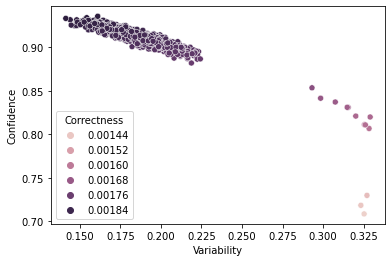

In [13]:
import seaborn as sns
import pandas as pd 
import matplotlib.pyplot as plt

# data = pd.DataFrame({'Variability': variablity_dict, 'Confidence': confidence_dict, 'Correctness': correctness_dict})
data = pd.read_pickle("eval.pkl")
sns.scatterplot(data=data, x="Variability", y="Confidence", hue="Correctness")
plt.show()

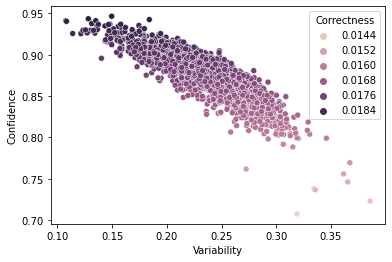

In [8]:
import seaborn as sns
import pandas as pd 
import matplotlib.pyplot as plt

# data = pd.DataFrame({'Variability': variablity_dict, 'Confidence': confidence_dict, 'Correctness': correctness_dict})
data = pd.read_pickle("eval.pkl")
sns.scatterplot(data=data, x="Variability", y="Confidence", hue="Correctness")
plt.legend(title='Correctness')
plt.show()

In [9]:
data["Correctness"].describe()

count    2077.000000
mean        0.017498
std         0.000551
min         0.014152
25%         0.017189
50%         0.017537
75%         0.017873
max         0.018931
Name: Correctness, dtype: float64